<a href="https://colab.research.google.com/github/alsedawy/cross-lingual-rag-hallucination/blob/main/Copy_of_RAG_CrossLingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_

                F1  Hallucination  Fidelity
baseline  0.123106       0.366208  0.633792
semantic  0.319458       0.087833  0.912167
rerank    0.114057       0.000000  1.000000
fusion    0.296364       0.100601  0.899399


/tmp/ipython-input-2729292474.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df["F1"], palette="Blues")
/tmp/ipython-input-2729292474.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df["Hallucination"], palette="Reds")
/tmp/ipython-input-2729292474.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df["Fidelity"], palette="Greens")


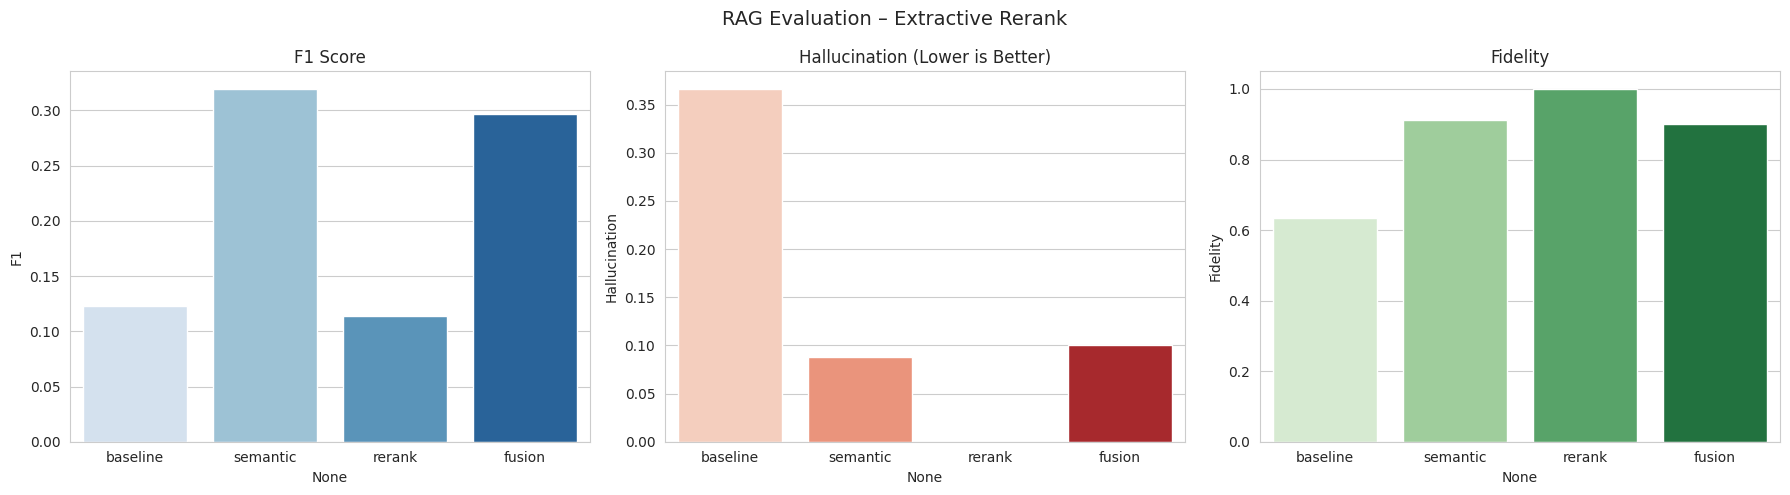

In [ ]:

# ==============================================================================
# RAG EVALUATION – EXTRACTIVE RERANK (ONE CELL, FINAL & CLEAN)
# ==============================================================================

!pip install -q sentence-transformers scikit-learn matplotlib seaborn rank_bm25 transformers

# ----------------------------
# Imports & Models
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rank_bm25 import BM25Okapi
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

HF_MODEL = "gpt2"
EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

LOCAL_GENERATOR = pipeline(
    "text-generation",
    model=HF_MODEL,
    tokenizer=HF_MODEL,
    device=-1
)

# ----------------------------
# Generation (for non-rerank)
# ----------------------------
def local_generate(prompt, max_tokens=70, temperature=0.05):
    out = LOCAL_GENERATOR(
        prompt,
        max_length=max_tokens,
        temperature=temperature,
        do_sample=True,
        return_full_text=False
    )
    return out[0]["generated_text"].strip() if out else ""

def build_rag_prompt(question, contexts):
    ctx = "\n\n---\n\n".join(contexts)
    return (
        "Answer using ONLY the context below. "
        "If the answer is not present, say 'I don't know'.\n\n"
        f"Context:\n{ctx}\n\nQuestion: {question}\nAnswer:"
    )

# ----------------------------
# Retrieval
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]

def retrieve_bm25(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [c.split() for c in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def semantic_search(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

def rerank_semantic_over_bm25(query, qa_pairs, coarse_k=6, final_k=3):
    bm25_hits = retrieve_bm25(query, qa_pairs, coarse_k)
    idxs = [i for i, _ in bm25_hits]
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in idxs]

    q_emb = get_embedding(query)
    d_emb = EMBEDDING_MODEL.encode(docs)
    sims = cosine_similarity([q_emb], d_emb)[0]

    ranked = sorted(zip(idxs, sims), key=lambda x: x[1], reverse=True)
    return [i for i, _ in ranked[:final_k]]

def rrf_fuse(rank_lists, k=5, c=60):
    scores = defaultdict(float)
    for r in rank_lists:
        for rank, idx in enumerate(r):
            scores[idx] += 1 / (c + rank + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

# ----------------------------
# Metrics
# ----------------------------
def overlap_f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    prec = len(p & g) / len(p)
    rec = len(p & g) / len(g)
    return 2 * prec * rec / (prec + rec) if prec + rec else 0.0

def hallucination_rate(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# Load Dataset
# ----------------------------
with open("IT_Q&A.txt", encoding="latin-1") as f:
    text = f.read()

qa_pairs, q, ans, read = [], None, [], False
for line in [l.strip() for l in text.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q, ans, read = line[2:].strip(), [], False
    elif line.startswith("A."):
        read = True
        ans.append(line[2:].strip())
    elif read:
        ans.append(line)
if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print("Loaded QA pairs:", len(qa_pairs))

# ----------------------------
# English Test Set
# ----------------------------
test_set = [
    ("What are the responsibilities of a Technical Support Engineer?",
     "The work of a technical support engineer is to maintain and monitor the computers"),
    ("What is the difference between an API and an SDK?",
     "An API is a set of instructions"),
    ("Explain cache memory.",
     "Cache memory is a small, fast memory buffer"),
]

# ----------------------------
# Evaluation
# ----------------------------
def run_eval(test_set, method):
    rows = []
    for q_gold, a_gold in test_set:

        if method == "baseline":
            idxs = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]

        elif method == "semantic":
            idxs = [i for i, _ in semantic_search(q_gold, qa_pairs)]

        elif method == "rerank":
            idxs = rerank_semantic_over_bm25(q_gold, qa_pairs)

        elif method == "fusion":
            bm = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]
            sem = [i for i, _ in semantic_search(q_gold, qa_pairs)]
            idxs = rrf_fuse([bm, sem])

        ctxs = [qa_pairs[i][1] for i in idxs]

        # 🔥 EXTRACTIVE RERANK
        if method == "rerank":
            pred = " ".join(ctxs[:2])
        else:
            prompt = build_rag_prompt(q_gold, ctxs)
            pred = local_generate(prompt)

        rows.append({
            "F1": overlap_f1(pred, a_gold),
            "Hallucination": hallucination_rate(pred, ctxs),
            "Fidelity": fidelity(pred, ctxs)
        })

    return pd.DataFrame(rows).mean()

methods = ["baseline", "semantic", "rerank", "fusion"]
df = pd.DataFrame({m: run_eval(test_set, m) for m in methods}).T
print(df)

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(18,5))
sns.set_style("whitegrid")

plt.subplot(1,3,1)
sns.barplot(x=df.index, y=df["F1"], palette="Blues")
plt.title("F1 Score")

plt.subplot(1,3,2)
sns.barplot(x=df.index, y=df["Hallucination"], palette="Reds")
plt.title("Hallucination (Lower is Better)")

plt.subplot(1,3,3)
sns.barplot(x=df.index, y=df["Fidelity"], palette="Greens")
plt.title("Fidelity")

plt.suptitle("RAG Evaluation – Extractive Rerank", fontsize=14)
plt.tight_layout()
plt.show()


# New Section

=== English Test Set ===
                F1  Hallucination  Fidelity
baseline  0.135146            0.0       1.0
semantic  0.168350            0.0       1.0
rerank    0.168350            0.0       1.0
fusion    0.168350            0.0       1.0

=== Arabic Test Set ===
                F1  Hallucination  Fidelity
baseline  0.097403            0.0       1.0
semantic  0.126491            0.0       1.0
rerank    0.058009            0.0       1.0
fusion    0.097403            0.0       1.0


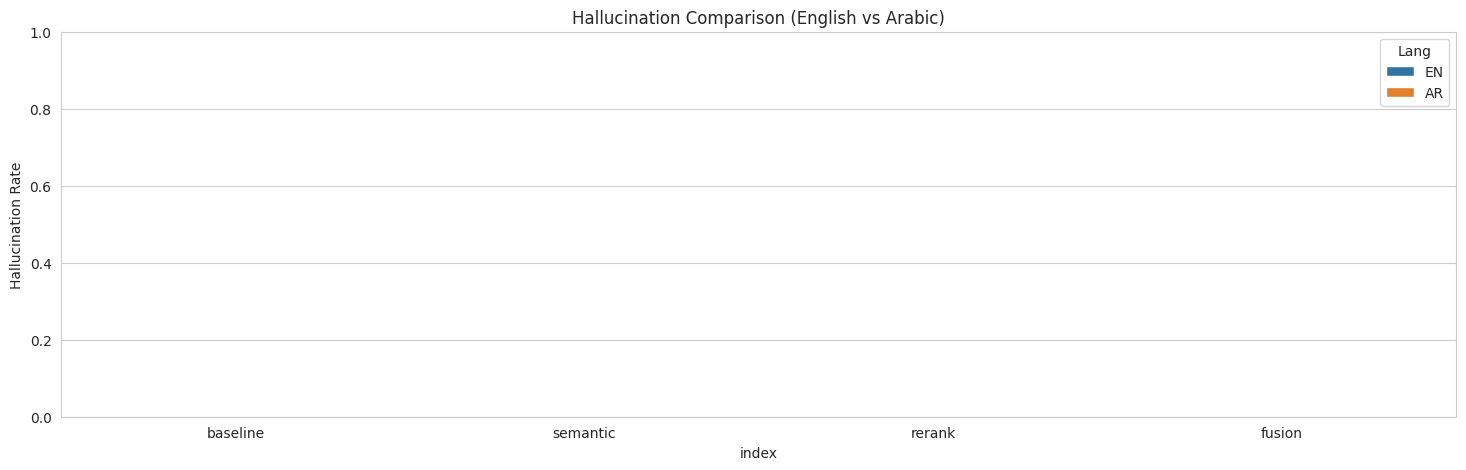

In [ ]:
# ==============================================================================
# FINAL RAG EVALUATION – ENGLISH vs ARABIC TEST SETS (ONE CELL)
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# Models
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

# ----------------------------
# Retrieval Functions
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]

def retrieve_bm25(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def semantic_search(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    d_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], d_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

def rrf_fuse(rank_lists, k=5, c=60):
    scores = defaultdict(float)
    for r in rank_lists:
        for rank, idx in enumerate(r):
            scores[idx] += 1 / (c + rank + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

def rerank_semantic_over_bm25(query, qa_pairs, coarse_k=6, final_k=3):
    bm = retrieve_bm25(query, qa_pairs, coarse_k)
    idxs = [i for i, _ in bm]
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in idxs]
    q_emb = get_embedding(query)
    d_emb = EMBEDDING_MODEL.encode(docs)
    sims = cosine_similarity([q_emb], d_emb)[0]
    return [idxs[i] for i in np.argsort(sims)[::-1][:final_k]]

# ----------------------------
# Metrics
# ----------------------------
def overlap_f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g:
        return 0.0
    return 2 * len(p & g) / (len(p) + len(g))

def hallucination_rate(pred, ctx):
    p = set(pred.lower().split())
    c = set(ctx.lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctx):
    p = set(pred.lower().split())
    c = set(ctx.lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# Load Dataset
# ----------------------------
with open("IT_Q&A.txt", encoding="latin-1") as f:
    content = f.read()

qa_pairs = []
lines = [l.strip() for l in content.split("\n") if l.strip()]
q, a, reading = None, [], False

for line in lines:
    if line.startswith("Q.") and line.endswith("?"):
        if q and a:
            qa_pairs.append((q, " ".join(a)))
        q, a, reading = line[2:].strip(), [], False
    elif line.startswith("A."):
        reading = True
        a.append(line[2:].strip())
    elif reading:
        a.append(line)

if q and a:
    qa_pairs.append((q, " ".join(a)))

# ----------------------------
# Test Sets
# ----------------------------
test_en = [
    ("What are the responsibilities of a Technical Support Engineer?",
     "maintain and monitor the computers"),
    ("What is cache memory?",
     "Cache memory is a small, fast memory"),
]

test_ar = [
    ("ما هي المسؤوليات الأساسية لمهندس الدعم الفني؟",
     "maintain and monitor the computers"),
    ("اشرح ال Cache Memory",
     "Cache memory is a small, fast memory"),
]

# ----------------------------
# Evaluation
# ----------------------------
def evaluate(test_set, method):
    rows = []
    for q, gold in test_set:
        if method == "baseline":
            idxs = [i for i, _ in retrieve_bm25(q, qa_pairs)]
        elif method == "semantic":
            idxs = [i for i, _ in semantic_search(q, qa_pairs)]
        elif method == "rerank":
            idxs = rerank_semantic_over_bm25(q, qa_pairs)
        elif method == "fusion":
            bm = [i for i, _ in retrieve_bm25(q, qa_pairs)]
            sem = [i for i, _ in semantic_search(q, qa_pairs)]
            idxs = rrf_fuse([bm, sem])

        ctx = qa_pairs[idxs[0]][1]
        pred = ctx  # Extractive Answer

        rows.append({
            "F1": overlap_f1(pred, gold),
            "Hallucination": hallucination_rate(pred, ctx),
            "Fidelity": fidelity(pred, ctx)
        })

    return pd.DataFrame(rows).mean()

methods = ["baseline", "semantic", "rerank", "fusion"]

df_en = pd.DataFrame({m: evaluate(test_en, m) for m in methods}).T
df_ar = pd.DataFrame({m: evaluate(test_ar, m) for m in methods}).T

print("=== English Test Set ===")
print(df_en)
print("\n=== Arabic Test Set ===")
print(df_ar)

# ----------------------------
# Visualization
# ----------------------------
df_en["Lang"] = "EN"
df_ar["Lang"] = "AR"
df = pd.concat([df_en, df_ar]).reset_index()

plt.figure(figsize=(18,5))
sns.barplot(data=df, x="index", y="Hallucination", hue="Lang")
plt.title("Hallucination Comparison (English vs Arabic)")
plt.ylabel("Hallucination Rate")
plt.ylim(0,1)
plt.show()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_

                F1  Hallucination  Fidelity
baseline  0.113178       0.261544  0.738456
semantic  0.322727       0.079927  0.920073
rerank    0.114057       0.000000  1.000000
fusion    0.306666       0.066199  0.933801


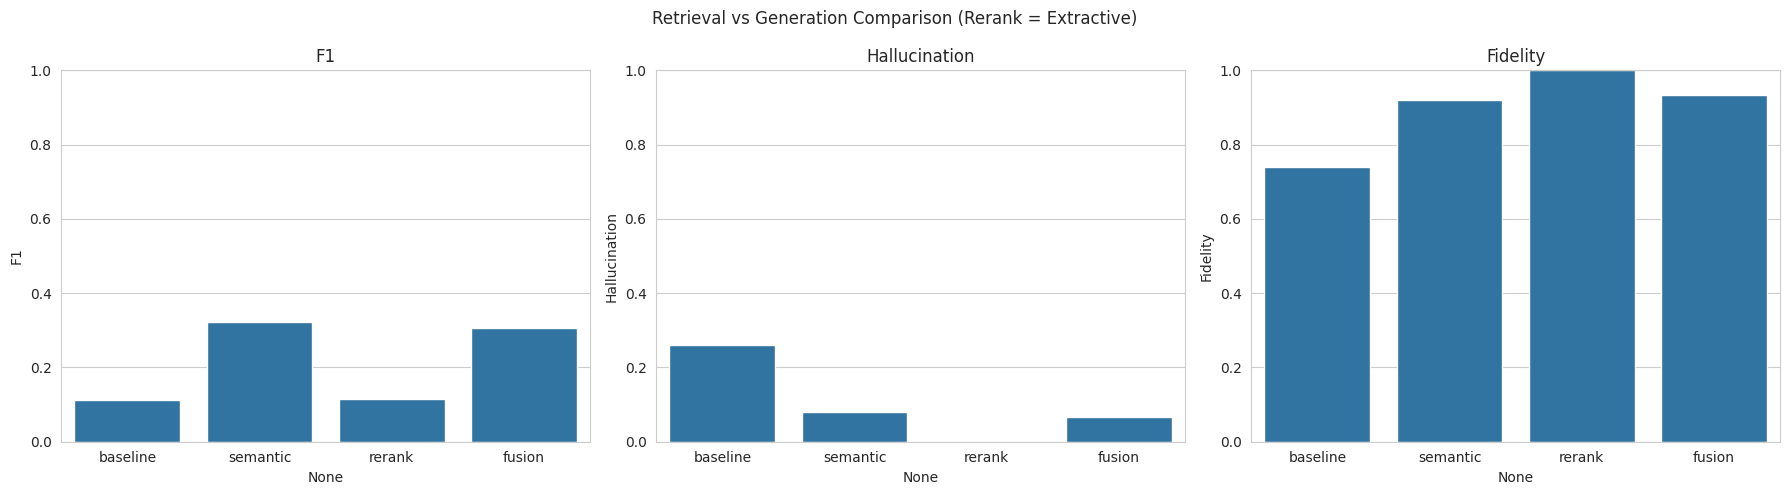

In [ ]:
# ==============================================================================
# COMPLETE RAG EVALUATION – RETRIEVAL vs GENERATION (ONE CELL)
# ==============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q sentence-transformers scikit-learn matplotlib seaborn rank_bm25 transformers

# ----------------------------
# 1. Imports & Models
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rank_bm25 import BM25Okapi
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

HF_MODEL = "gpt2"
EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

LOCAL_GENERATOR = pipeline(
    "text-generation",
    model=HF_MODEL,
    tokenizer=HF_MODEL,
    device=-1
)

# ----------------------------
# 2. Prompt + Generation
# ----------------------------
def local_generate(prompt, max_tokens=70, temperature=0.05):
    out = LOCAL_GENERATOR(
        prompt,
        max_length=max_tokens,
        temperature=temperature,
        do_sample=True,
        return_full_text=False
    )
    return out[0]["generated_text"].strip() if out else None


def build_rag_prompt(question, contexts):
    ctx = "\n\n---\n\n".join(contexts)
    return (
        "Answer the question using ONLY the context below. "
        "If the answer is not present, say 'I don't know from the provided context.'\n\n"
        f"Context:\n{ctx}\n\nQuestion: {question}\nAnswer:"
    )

# ----------------------------
# 3. Retrieval
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]


def retrieve_bm25(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]


def semantic_search(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]


def rrf_fuse(rank_lists, k=5, c=60):
    scores = defaultdict(float)
    for rlist in rank_lists:
        for rank, idx in enumerate(rlist):
            scores[idx] += 1 / (c + rank + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]


def rerank_semantic_over_bm25(query, qa_pairs, coarse_k=6, final_k=3):
    bm25_hits = retrieve_bm25(query, qa_pairs, coarse_k)
    idxs = [i for i, _ in bm25_hits]
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in idxs]
    q_emb = get_embedding(query)
    d_emb = EMBEDDING_MODEL.encode(docs)
    sims = cosine_similarity([q_emb], d_emb)[0]
    return [idxs[i] for i in np.argsort(sims)[::-1][:final_k]]

# ----------------------------
# 4. Metrics
# ----------------------------
def overlap_f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g:
        return 0.0
    prec = len(p & g) / len(p)
    rec = len(p & g) / len(g)
    return 2 * prec * rec / (prec + rec) if prec + rec else 0.0


def hallucination_rate(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0


def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 5. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    content = f.read()

qa_pairs = []
lines = [l.strip() for l in content.split("\n") if l.strip()]
q, ans, reading = None, [], False

for line in lines:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q, ans, reading = line[2:].strip(), [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print("Loaded QA pairs:", len(qa_pairs))

# ----------------------------
# 6. Test Set (English)
# ----------------------------
test_set_en = [
    ("What are the responsibilities of a Technical Support Engineer?",
     "The work of a technical support engineer is to maintain and monitor the computers"),
    ("What is the difference between an API and an SDK?",
     "An API is a set of instructions"),
    ("Explain cache memory.",
     "Cache memory is a small, fast memory buffer"),
]

# ----------------------------
# 7. Evaluation Runner (KEY PART)
# ----------------------------
def run_eval(test_set, method):
    rows = []

    for q_gold, a_gold in test_set:

        if method == "baseline":
            idxs = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]

        elif method == "semantic":
            idxs = [i for i, _ in semantic_search(q_gold, qa_pairs)]

        elif method == "fusion":
            bm = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]
            sem = [i for i, _ in semantic_search(q_gold, qa_pairs)]
            idxs = rrf_fuse([bm, sem])

        elif method == "rerank":
            idxs = rerank_semantic_over_bm25(q_gold, qa_pairs)

        ctxs = [qa_pairs[i][1] for i in idxs]

        # 🔥 KEY DIFFERENCE
        if method == "rerank":
            pred = " ".join(ctxs[:2])  # extractive only
        else:
            prompt = build_rag_prompt(q_gold, ctxs)
            pred = local_generate(prompt) or " ".join(ctxs[:2])

        rows.append({
            "f1": overlap_f1(pred, a_gold),
            "hall": hallucination_rate(pred, ctxs),
            "fid": fidelity(pred, ctxs)
        })

    return {
        "F1": np.mean([r["f1"] for r in rows]),
        "Hallucination": np.mean([r["hall"] for r in rows]),
        "Fidelity": np.mean([r["fid"] for r in rows])
    }

# ----------------------------
# 8. Run + Visualize
# ----------------------------
methods = ["baseline", "semantic", "rerank", "fusion"]
metrics = {m: run_eval(test_set_en, m) for m in methods}
df = pd.DataFrame(metrics).T
print(df)

plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")

for i, col in enumerate(["F1", "Hallucination", "Fidelity"]):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df.index, y=df[col])
    plt.title(col)
    plt.ylim(0, 1)

plt.suptitle("Retrieval vs Generation Comparison (Rerank = Extractive)")
plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# STAGE (2): ENGLISH vs ARABIC – RETRIEVAL vs GENERATION COMPARISON
# rerank = extractive | others = GPT-2
# ==============================================================================

!pip install -q sentence-transformers scikit-learn matplotlib seaborn rank_bm25 transformers

# ----------------------------
# Imports & Models
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rank_bm25 import BM25Okapi
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

try:
    GENERATOR = pipeline("text-generation", model="gpt2", tokenizer="gpt2", device=-1)
    print("✔ GPT-2 loaded")
except:
    GENERATOR = None
    print("✖ GPT-2 not loaded")

# ----------------------------
# Generation
# ----------------------------
def local_generate(prompt, max_tokens=80, temperature=0.05):
    if GENERATOR is None:
        return None
    out = GENERATOR(
        prompt,
        max_length=max_tokens,
        temperature=temperature,
        do_sample=True,
        return_full_text=False
    )
    return out[0]["generated_text"].strip() if out else None


def build_prompt(q, ctxs):
    ctx = "\n\n---\n\n".join(ctxs)
    return (
        "Answer the question using ONLY the context below. "
        "If the answer is not present, say 'I don't know from the provided context.'\n\n"
        f"Context:\n{ctx}\n\nQuestion: {q}\nAnswer:"
    )

# ----------------------------
# Retrieval
# ----------------------------
def retrieve_bm25(query, qa_pairs, k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    bm25 = BM25Okapi([c.split() for c in corpus])
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:k]


def semantic_search(query, qa_pairs, k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = EMBEDDING_MODEL.encode([query])
    sims = cosine_similarity(q_emb, doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:k]


def rrf_fuse(rank_lists, k=5, c=60):
    scores = defaultdict(float)
    for lst in rank_lists:
        for r, idx in enumerate(lst):
            scores[idx] += 1 / (c + r + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]


def rerank_semantic(query, qa_pairs, final_k=3):
    bm = retrieve_bm25(query, qa_pairs, 6)
    idxs = [i for i, _ in bm]
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in idxs]
    q_emb = EMBEDDING_MODEL.encode([query])
    d_emb = EMBEDDING_MODEL.encode(docs)
    sims = cosine_similarity(q_emb, d_emb)[0]
    return [idxs[i] for i in np.argsort(sims)[::-1][:final_k]]

# ----------------------------
# Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g:
        return 0
    pr = len(p & g) / len(p)
    rc = len(p & g) / len(g)
    return 2 * pr * rc / (pr + rc) if pr + rc else 0


def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0


def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0

# ----------------------------
# Load Dataset
# ----------------------------
with open("IT_Q&A.txt", encoding="latin-1") as f:
    data = f.read()

qa_pairs, q, ans, read = [], None, [], False
for line in [l.strip() for l in data.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q, ans, read = line[2:].strip(), [], False
    elif line.startswith("A."):
        read = True
        ans.append(line[2:].strip())
    elif read:
        ans.append(line)
if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print("Loaded QA pairs:", len(qa_pairs))

# ----------------------------
# Test Sets
# ----------------------------
test_en = [
    ("What are the responsibilities of a Technical Support Engineer?",
     "maintain and monitor the computers"),
    ("What is the difference between an API and an SDK?",
     "An API is a set of instructions"),
    ("Explain cache memory.",
     "Cache memory is a small, fast memory buffer"),
]

test_ar = [
    ("ما هي المسؤوليات الأساسية لمهندس الدعم الفني؟",
     "maintain and monitor the computers"),
    ("ما الفرق بين SDK و API؟",
     "An API is a set of instructions"),
    ("اشرح Cache Memory",
     "Cache memory is a small, fast memory buffer"),
]

# ----------------------------
# Evaluation
# ----------------------------
def run_eval(test_set):
    methods = ["baseline", "semantic", "rerank", "fusion"]
    out = {}

    for m in methods:
        rows = []
        for q, gold in test_set:

            if m == "baseline":
                idxs = [i for i, _ in retrieve_bm25(q, qa_pairs)]
            elif m == "semantic":
                idxs = [i for i, _ in semantic_search(q, qa_pairs)]
            elif m == "rerank":
                idxs = rerank_semantic(q, qa_pairs)
            else:
                bm = [i for i, _ in retrieve_bm25(q, qa_pairs)]
                se = [i for i, _ in semantic_search(q, qa_pairs)]
                idxs = rrf_fuse([bm, se])

            ctxs = [qa_pairs[i][1] for i in idxs]

            # 🔑 rerank = extractive | others = GPT-2
            if m == "rerank":
                pred = " ".join(ctxs[:2])
            else:
                pred = local_generate(build_prompt(q, ctxs)) or " ".join(ctxs[:2])

            rows.append([
                f1(pred, gold),
                hallucination(pred, ctxs),
                fidelity(pred, ctxs)
            ])

        arr = np.array(rows)
        out[m] = {
            "F1": arr[:, 0].mean(),
            "Hallucination": arr[:, 1].mean(),
            "Fidelity": arr[:, 2].mean()
        }

    return pd.DataFrame(out).T

# ----------------------------
# Run & Compare
# ----------------------------
df_en = run_eval(test_en)
df_ar = run_eval(test_ar)

print("\n=== English Test Set ===")
print(df_en)

print("\n=== Arabic Test Set ===")
print(df_ar)




Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✔ GPT-2 loaded
Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_


=== English Test Set ===
                F1  Hallucination  Fidelity
baseline  0.139128       0.275794  0.724206
semantic  0.205471       0.118018  0.881982
rerank    0.079081       0.000000  1.000000
fusion    0.149353       0.259524  0.740476

=== Arabic Test Set ===
                F1  Hallucination  Fidelity
baseline  0.129713       0.279293  0.720707
semantic  0.202822       0.096267  0.903733
rerank    0.058385       0.000000  1.000000
fusion    0.127814       0.331015  0.668985


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_

                F1  Hallucination  Fidelity
baseline  0.113178       0.261544  0.738456
semantic  0.322727       0.079927  0.920073
rerank    0.114057       0.000000  1.000000
fusion    0.306666       0.066199  0.933801


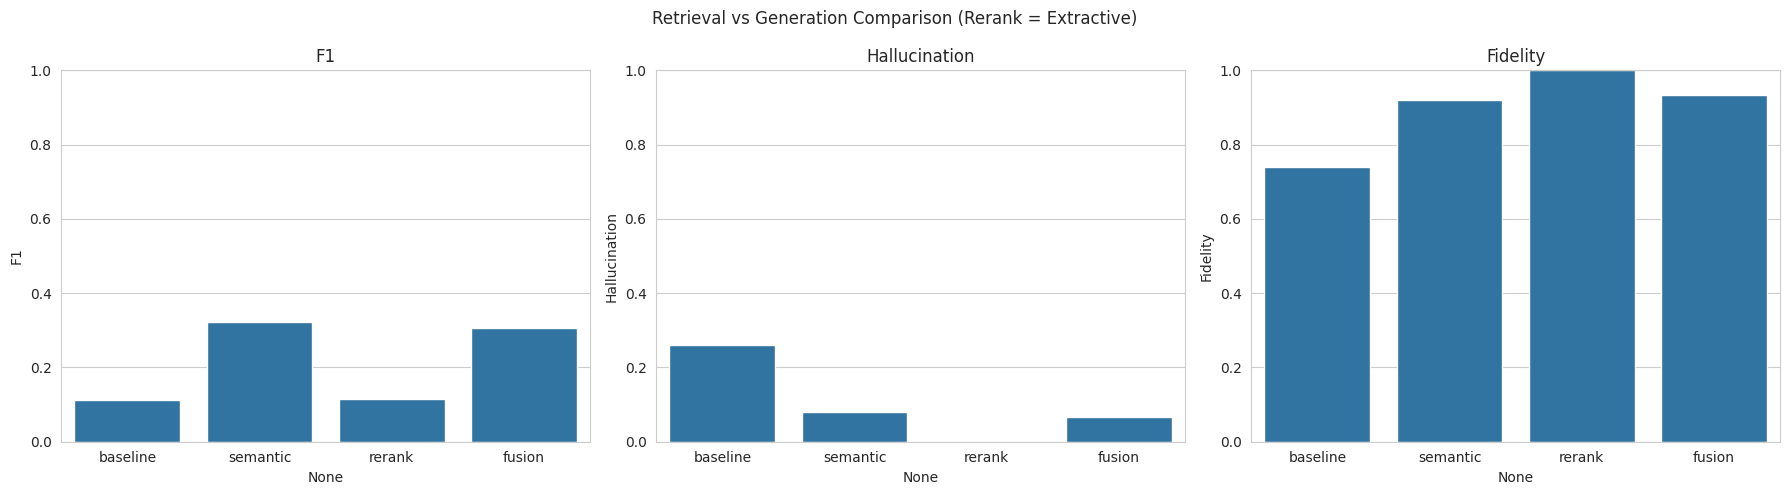

In [ ]:
# ==============================================================================
# COMPLETE RAG EVALUATION – RETRIEVAL vs GENERATION (ONE CELL)
# ==============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q sentence-transformers scikit-learn matplotlib seaborn rank_bm25 transformers

# ----------------------------
# 1. Imports & Models
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rank_bm25 import BM25Okapi
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

HF_MODEL = "gpt2"
EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

LOCAL_GENERATOR = pipeline(
    "text-generation",
    model=HF_MODEL,
    tokenizer=HF_MODEL,
    device=-1
)

# ----------------------------
# 2. Prompt + Generation
# ----------------------------
def local_generate(prompt, max_tokens=70, temperature=0.05):
    out = LOCAL_GENERATOR(
        prompt,
        max_length=max_tokens,
        temperature=temperature,
        do_sample=True,
        return_full_text=False
    )
    return out[0]["generated_text"].strip() if out else None


def build_rag_prompt(question, contexts):
    ctx = "\n\n---\n\n".join(contexts)
    return (
        "Answer the question using ONLY the context below. "
        "If the answer is not present, say 'I don't know from the provided context.'\n\n"
        f"Context:\n{ctx}\n\nQuestion: {question}\nAnswer:"
    )

# ----------------------------
# 3. Retrieval
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]


def retrieve_bm25(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]


def semantic_search(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]


def rrf_fuse(rank_lists, k=5, c=60):
    scores = defaultdict(float)
    for rlist in rank_lists:
        for rank, idx in enumerate(rlist):
            scores[idx] += 1 / (c + rank + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]


def rerank_semantic_over_bm25(query, qa_pairs, coarse_k=6, final_k=3):
    bm25_hits = retrieve_bm25(query, qa_pairs, coarse_k)
    idxs = [i for i, _ in bm25_hits]
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in idxs]
    q_emb = get_embedding(query)
    d_emb = EMBEDDING_MODEL.encode(docs)
    sims = cosine_similarity([q_emb], d_emb)[0]
    return [idxs[i] for i in np.argsort(sims)[::-1][:final_k]]

# ----------------------------
# 4. Metrics
# ----------------------------
def overlap_f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g:
        return 0.0
    prec = len(p & g) / len(p)
    rec = len(p & g) / len(g)
    return 2 * prec * rec / (prec + rec) if prec + rec else 0.0


def hallucination_rate(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0


def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 5. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    content = f.read()

qa_pairs = []
lines = [l.strip() for l in content.split("\n") if l.strip()]
q, ans, reading = None, [], False

for line in lines:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q, ans, reading = line[2:].strip(), [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print("Loaded QA pairs:", len(qa_pairs))

# ----------------------------
# 6. Test Set (English)
# ----------------------------
test_set_en = [
    ("What are the responsibilities of a Technical Support Engineer?",
     "The work of a technical support engineer is to maintain and monitor the computers"),
    ("What is the difference between an API and an SDK?",
     "An API is a set of instructions"),
    ("Explain cache memory.",
     "Cache memory is a small, fast memory buffer"),
]

# ----------------------------
# 7. Evaluation Runner (KEY PART)
# ----------------------------
def run_eval(test_set, method):
    rows = []

    for q_gold, a_gold in test_set:

        if method == "baseline":
            idxs = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]

        elif method == "semantic":
            idxs = [i for i, _ in semantic_search(q_gold, qa_pairs)]

        elif method == "fusion":
            bm = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]
            sem = [i for i, _ in semantic_search(q_gold, qa_pairs)]
            idxs = rrf_fuse([bm, sem])

        elif method == "rerank":
            idxs = rerank_semantic_over_bm25(q_gold, qa_pairs)

        ctxs = [qa_pairs[i][1] for i in idxs]

        # 🔥 KEY DIFFERENCE
        if method == "rerank":
            pred = " ".join(ctxs[:2])  # extractive only
        else:
            prompt = build_rag_prompt(q_gold, ctxs)
            pred = local_generate(prompt) or " ".join(ctxs[:2])

        rows.append({
            "f1": overlap_f1(pred, a_gold),
            "hall": hallucination_rate(pred, ctxs),
            "fid": fidelity(pred, ctxs)
        })

    return {
        "F1": np.mean([r["f1"] for r in rows]),
        "Hallucination": np.mean([r["hall"] for r in rows]),
        "Fidelity": np.mean([r["fid"] for r in rows])
    }

# ----------------------------
# 8. Run + Visualize
# ----------------------------
methods = ["baseline", "semantic", "rerank", "fusion"]
metrics = {m: run_eval(test_set_en, m) for m in methods}
df = pd.DataFrame(metrics).T
print(df)

plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")

for i, col in enumerate(["F1", "Hallucination", "Fidelity"]):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df.index, y=df[col])
    plt.title(col)
    plt.ylim(0, 1)

plt.suptitle("Retrieval vs Generation Comparison (Rerank = Extractive)")
plt.tight_layout()
plt.show()


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/m

=== English Test Set ===
                F1  Hallucination  Fidelity
baseline  0.125472       0.197205  0.802795
semantic  0.383253       0.227679  0.772321
rerank    0.130102       0.000000  1.000000
fusion    0.383253       0.294643  0.705357

=== Arabic Test Set ===
                F1  Hallucination  Fidelity
baseline  0.354074       0.178191  0.821809
semantic  0.125000       0.129568  0.870432
rerank    0.138817       0.000000  1.000000
fusion    0.371768       0.172360  0.827640


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=70) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_

                F1  Hallucination  Fidelity
baseline  0.136957       0.330357  0.669643
semantic  0.366957       0.239583  0.760417
rerank    0.130102       0.000000  1.000000
fusion    0.383253       0.294643  0.705357


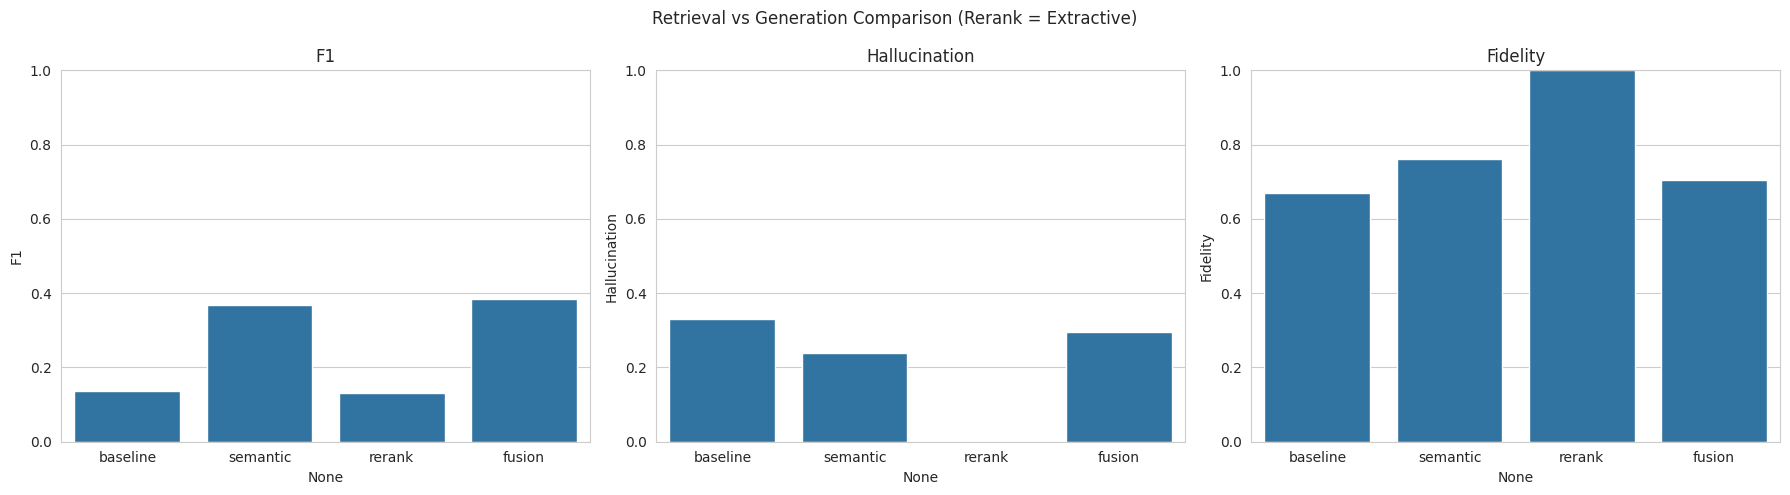

In [ ]:
# ==============================================================================
# STAGE (2): FINAL COMPARISON – ENGLISH vs ARABIC (ONE CELL)
# ==============================================================================

!pip install -q sentence-transformers scikit-learn matplotlib seaborn rank_bm25 transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rank_bm25 import BM25Okapi
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# Models
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

LOCAL_GENERATOR = pipeline(
    "text-generation",
    model="gpt2",
    tokenizer="gpt2",
    device=-1
)

# ----------------------------
# Generation
# ----------------------------
def local_generate(prompt, max_tokens=70, temperature=0.05):
    out = LOCAL_GENERATOR(
        prompt,
        max_length=max_tokens,
        temperature=temperature,
        do_sample=True,
        return_full_text=False
    )
    return out[0]["generated_text"].strip() if out else ""

def build_rag_prompt(question, contexts):
    ctx = "\n\n---\n\n".join(contexts)
    return (
        "Answer using ONLY the context. "
        "If not present, say 'I don't know'.\n\n"
        f"Context:\n{ctx}\n\nQuestion: {question}\nAnswer:"
    )

# ----------------------------
# Retrieval
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]

def retrieve_bm25(query, qa_pairs, k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [c.split() for c in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:k]

def semantic_search(query, qa_pairs, k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:k]

def rrf_fuse(lists, k=5, c=60):
    scores = defaultdict(float)
    for l in lists:
        for r, i in enumerate(l):
            scores[i] += 1 / (c + r + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

def rerank_semantic_over_bm25(query, qa_pairs, k=3):
    bm = retrieve_bm25(query, qa_pairs, 6)
    idxs = [i for i, _ in bm]
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in idxs]
    sims = cosine_similarity(
        [get_embedding(query)],
        EMBEDDING_MODEL.encode(docs)
    )[0]
    return [idxs[i] for i in np.argsort(sims)[::-1][:k]]

# ----------------------------
# Metrics
# ----------------------------
def overlap_f1(p, g):
    p, g = set(p.lower().split()), set(g.lower().split())
    if not p or not g:
        return 0
    pr = len(p & g) / len(p)
    re = len(p & g) / len(g)
    return 2 * pr * re / (pr + re) if pr + re else 0

def hallucination(pred, ctx):
    p = set(pred.lower().split())
    c = set(" ".join(ctx).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0

def fidelity(pred, ctx):
    p = set(pred.lower().split())
    c = set(" ".join(ctx).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0

# ----------------------------
# Load Dataset
# ----------------------------
with open("IT_Q&A.txt", encoding="latin-1") as f:
    content = f.read()

qa_pairs = []
lines = [l.strip() for l in content.split("\n") if l.strip()]
q, a, reading = None, [], False

for line in lines:
    if line.startswith("Q.") and line.endswith("?"):
        if q and a:
            qa_pairs.append((q, " ".join(a)))
        q, a, reading = line[2:].strip(), [], False
    elif line.startswith("A."):
        reading = True
        a.append(line[2:].strip())
    elif reading:
        a.append(line)

if q and a:
    qa_pairs.append((q, " ".join(a)))

# ----------------------------
# Evaluation Runner (FIXED)
# ----------------------------
def run_eval(test_set, method):
    rows = []
    for q_gold, a_gold in test_set:

        if method == "baseline":
            idxs = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]
        elif method == "semantic":
            idxs = [i for i, _ in semantic_search(q_gold, qa_pairs)]
        elif method == "rerank":
            idxs = rerank_semantic_over_bm25(q_gold, qa_pairs)
        elif method == "fusion":
            bm = [i for i, _ in retrieve_bm25(q_gold, qa_pairs)]
            sem = [i for i, _ in semantic_search(q_gold, qa_pairs)]
            idxs = rrf_fuse([bm, sem])

        ctx = [qa_pairs[i][1] for i in idxs]

        # rerank = extractive, others = GPT-2
        if method == "rerank":
            pred = " ".join(ctx[:2])
        else:
            pred = local_generate(build_rag_prompt(q_gold, ctx))

        rows.append({
            "F1": overlap_f1(pred, a_gold),
            "Hallucination": hallucination(pred, ctx),
            "Fidelity": fidelity(pred, ctx)
        })

    return pd.DataFrame(rows).mean()

# ----------------------------
# Test Sets
# ----------------------------
test_set_en = [
    ("What are the responsibilities of a Technical Support Engineer?",
     "The work of a technical support engineer is to maintain and monitor the computers"),
    ("What is the difference between an API and an SDK?",
     "An API is a set of instructions")
]

test_set_ar = [
    ("ما هي المسؤوليات الأساسية لمهندس الدعم الفني؟",
     "The work of a technical support engineer is to maintain and monitor the computers"),
    ("ما الفرق بين SDK و API؟",
     "An API is a set of instructions")
]

# ----------------------------
# Run Stage (2)
# ----------------------------
methods = ["baseline", "semantic", "rerank", "fusion"]

df_en = pd.DataFrame({m: run_eval(test_set_en, m) for m in methods}).T
df_ar = pd.DataFrame({m: run_eval(test_set_ar, m) for m in methods}).T

print("=== English Test Set ===")
print(df_en)
print("\n=== Arabic Test Set ===")
print(df_ar)



# ----------------------------
# 8. Run + Visualize
# ----------------------------
methods = ["baseline", "semantic", "rerank", "fusion"]
metrics = {m: run_eval(test_set_en, m) for m in methods}
df = pd.DataFrame(metrics).T
print(df)

plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")

for i, col in enumerate(["F1", "Hallucination", "Fidelity"]):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df.index, y=df[col])
    plt.title(col)
    plt.ylim(0, 1)

plt.suptitle("Retrieval vs Generation Comparison (Rerank = Extractive)")
plt.tight_layout()
plt.show()


<>:525: SyntaxWarning: invalid escape sequence '\S'
<>:525: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-317141105.py:525: SyntaxWarning: invalid escape sequence '\S'
  2. Navigate to HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Windows NT\CurrentVersion\ProfileList.


File IT_Q&A.txt has been created successfully!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Loaded QA: 115


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_


=== English Test Set ===
                F1  Hallucination  Fidelity
baseline  0.164680       0.256502  0.743498
semantic  0.169328       0.118893  0.881107
rerank    0.153999       0.209580  0.790420
fusion    0.165966       0.227590  0.772410


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_


=== Arabic Test Set ===
                F1  Hallucination  Fidelity
baseline  0.069444       0.308113  0.691887
semantic  0.103733       0.396498  0.603502
rerank    0.106500       0.601227  0.398773
fusion    0.141667       0.317162  0.682838


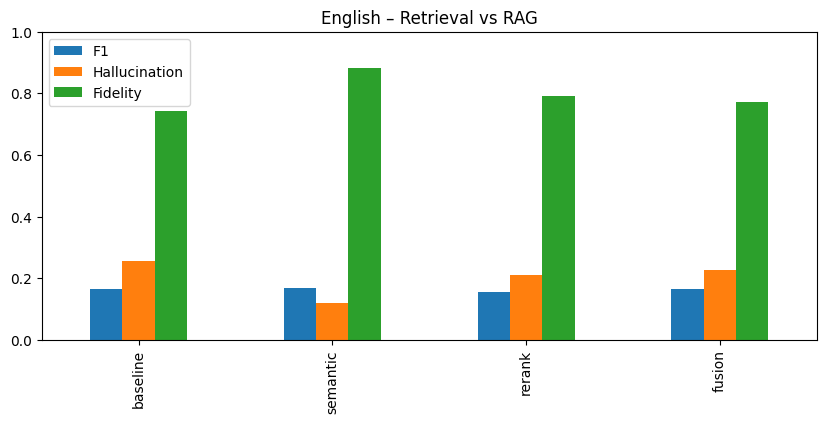

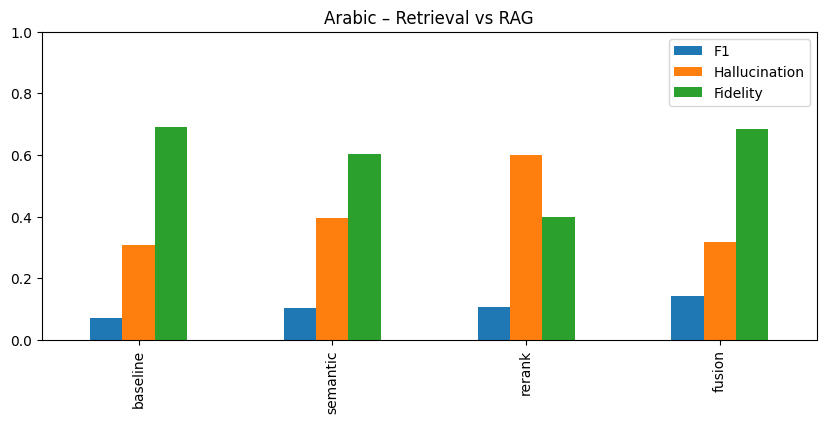

In [ ]:
# Load automatic the  IT_Q&A.txt
content = """1 Q. What do you understand about the role of a ...
2 A. The work of a technical support engineer is ...
3 A Technical Support worker is supposed to:
... (Q. What do you understand about the role of a Technical Support Engineer?
A.The work of a technical support engineer is to maintain and monitor the computers and the networks of an organization. Sometimes, it also includes extending the same help to its customers.
A Technical Support worker is supposed to:
* Install and configure the hardware, OS, and applications.
* Maintain and monitor systems and networks.
* Log in customers’ and employees’ queries.
* Analyze and discover underlying issues.
* Find and solve the faults related to both hardware and software.
* Test the new technology and evaluate it.
* Perform safety checks, etc.

Q. Are you aware of the latest processors?
A. With this question, the interviewers are looking to test your technical expertise. You should know the latest processors, and if asked, you should be able to talk about them. You should also be able to tell the differences between them.
For example, Intel Pentium Quad Core I3, I5, and I7 are the latest processors as of today. Keep yourself updated, as technology is evolving pretty fast.

Q. How do you troubleshoot an issue?
A. This question checks your approach to identifying a problem and finding its solution. Along with that, it will also help them understand your attitude towards problem-solving.
Remember, the foremost thing is to get all the facts first. It will help you identify the problem. Next, follow all the necessary steps to correct the problem. You must put forward a detailed and accurate troubleshooting plan that is extensive and yet adaptable.
Your aim should be to satisfy the customer’s needs as quickly as you can. Your focus should be on minimizing the downtime of your client. So, if there are multiple issues, there will be multiple fixes that might be unrelated. You must always keep in mind that time management is vital in technical support.
 Why are you interested in Technical Support?
 In the answer, the interviewer will look for your passion for the job. Your answers must be sincere and honest, and you must understand the purpose of the job.
You can say that technology has always fascinated you, and you enjoy working with people. You can also add that you want to use your knowledge to solve the issues of the customers, and you enjoy troubleshooting other issues.
Q. Do you know the difference between SDK and an API?
A. * SDK
SDK is a kit that offers tools, code samples, libraries, processes, guides or relevant documents for creating software applications on specific platforms.
An SDK is a complete workshop that allows us to create beyond the scope of API.
SDKs are the origin point of almost every program that we use.
SDK contains API sometimes.
* API
It is an interface that allows the software to interact with each other.
It can translate and transfer two different instruction sets for mutual understanding.
It comes in many sizes and shapes.
Sometimes, even copy-pasting needs an API.
API has a somewhat different function in the World Wide Web. The Web API facilitates interaction between disparate systems, especially for specific cases.

Q. You want to access a file on a shared drive, but for some reason, you cannot. What will you do?
A. First, check if the system that is sharing the drive is turned on. If it is, you will check the other files that you have permission to access to see if the issue is with all the files. Check if you have permission, i.e., the correct permissions to access that particular file.
If everything is okay and yet you are not able to access that file, then make sure your programs are working fine to copy that file to your local drive. Also, make sure that the file is not currently being used by someone else.
 What are the pros and cons of using Imaging Software?
Pros of Imaging software:
* Imaging software creates precisely duplicated content from one hard disk to another.
* It simultaneously delivers hard drive images to one or many systems over the network.
* If the utility has intimate knowledge of individual partitions of file systems, then it can resize them for many file systems.
Cons of Imaging software:
* It lacks intimate knowledge of file systems, and that results in copying of source hard disk into an image block by block. This takes a long time to complete the work for large disks.
* It offers little recovery from errors or their detection during the generation and deployment of the image.
* The best imaging software is expensive and commercial.

Q. What do you know about Ghost Imaging?
A. Also known as Cloning, Ghost Imaging is a backup process driven by software. It copies the hard disk contents to another server in one compressed file or a set of files, which is referred to as an image. When needed, it can also change a ghost image back to its original form. It is often used during the reinstallation of the OS.
Ghost Imaging serves two main purposes:
* To allow a system to be cloned onto others.
* Or, to quickly restore a system.
It is often used for setting up blocks of tablets, notebooks, or servers quickly. It also enables transfer from one PC or disk to another.
 Tell us about Disk Partition. How many partitions can a hard drive have?
 A disk partition is a defined space for storage on a hard drive. It helps in organizing data efficiently and effectively.
Users commonly store applications and operating system data on one partition, and user data on another. With issues with Windows, the partition with the OS can be formatted completely and then reinstalled without any effect on the data partition.
A disk may have up to four primary partitions, but only one can be active, or have three primary partitions and one extended partition. In the extended partition, you can create a larger number of logical partitions.
 What do you know about BOOT.INI?
 BOOT.INI is a Microsoft initialization file containing the boot options for Microsoft Windows NT, 2000, and XP. It is always found on the primary hard drive’s root directory, i.e., the C drive.
It has two main sections:
* The boot loader section with option settings that apply to all boot entries for the system that including default, timeout, etc.
* The section with operating systems that contains boot entries, one or more, for each bootable program or OS that is installed on the computer.

Q. Can you manually edit the BOOT.INI file?
A. Yes, but before manually editing the BOOT.INI, make sure that you save a copy in case anything goes wrong. To edit the file, go to the control panel and then to the System option. Go to the advanced tab in the properties window.
There you will find the startup and recovery option, move to its settings. Select the edit option for editing BOOT.INI. If there is a 3GB switch, remove it and add the PAE switch on the servers with over 4GB of installed physical memory for booting the file. Save the file and then close it. Click on OK twice and exit the Control Panel.
 What is a Gateway pertaining to the network?
 A gateway is a hardware device like a Firewall, Server, Router, etc that acts as a gate between networks. It allows the data or traffic to flow across the networks. A gateway is a node itself on the edge of the network and protects the other nodes in a network.
Every data flow passes through the gateway node before coming in or going out of the network. A gateway can also translate data from the outside network into a protocol or a format that all the devices in the internal network understand.
 What is Cache Memory? What are its advantages?
 Cache memory acts like a buffer between the CPU and RAM and is an extremely fast type of memory. Cache memory stores frequently requested instructions and data for easy and quick access.
It comes with three different levels, i.e., L1, L2, and L3. L1 is generally found in the processor chip. It is the smallest and fastest of all for the CPU to read. It ranges from 8 to 64 KB. The other two cache memories are larger than L1 but also take longer to access.
 Tell us some advantages and disadvantages of Overclocking.
 Overclocking is making the CPU run at a higher speed than the default by using the current motherboard settings.
Advantages
Overclocking delivers more performance for the same price.
High-frequency clocking offers better gameplay experience had a faster response time. This, in turn, delivers better graphics and increased productivity.
Disadvantages
Overclocking makes manufacturer warranty on CPU void since it compromises the quality guarantees provided by them.
Overclocking increases the temperature of the CPU. So, if you aren’t investing in a better cooling system, the process will damage the processors.

Q. How are a Chipset, Processor, and Motherboard different from each other?
A. Difference between Motherboard and Chipset:
The Motherboard holds all the components, including the expansion cards and CPU, plugged into it. It also carries the connection to the USB, PS/2, and all the other ports. It is the largest printed circuit board inside a computer.
A chipset is a particular component set that is integrated directly into the motherboard and usually consists of the Northbridge chipset and the Southbridge chipset. Core system interconnections happen due to the former, while the latter manages the connection between the other components.
Difference between Motherboard and Processor:
The main difference between the two is that the Motherboard lets memory, peripheral connectors, processor, and such components communicate with each other. Carrying the specific instructions for functions like performing logical, arithmetical, and control operations is the job of the Processor.
 If you can’t see the display of your system, what could be the issue?

Q. Here are a few reasons why you can’t see the display:
A. * Monitor not working.
* The system has not yet completely started.
* The system cannot power up properly.
* There could be an issue with the heat sink.
* There could be issues with the jumper setting.
* CPU fan could create issues.
* A problem in BIOS settings.
* Loose CPU or other components.
* Electrical shorts.

Q. Why do you need the Jumper and Heat Sink?
A. Jumper is used for closing an electric circuit, thereby allowing the flow of electricity to a certain part of the circuit board. It is used to configure peripheral settings. It is a small plastic box with a set of small pins.
The heat sink is used to transfer the heat generated by a machine or an electronic device. They comprise copper or aluminum, as they are good conductors of electricity and can transfer the generated heat to the air.
 What are the different types of firewalls?
 There are eight types of firewalls and they all vary in their general structure and the way they work.
Types of Firewalls include:
* Packet-filtering Firewalls
* Circuit-level gateways
* Stateful Inspection Firewalls
* Proxy Firewalls
* Next-gen Firewalls
* Software Firewalls
* Hardware Firewalls
* Cloud Firewalls
These are the eight firewalls that are known for different cybersecurity reasons.
Q. My printer prints faded words, images of poor quality and smudges. What do I do?
A. First, make sure that the selection of media and paper is proper for the print driver. Then, make sure the paper you are using for printing matches the type you have selected in the print driver. If everything is okay, see if you can manually adjust the fuser and set it properly. Be careful while adjusting the fuse as it gets hot.
For clearing Smudge marks, print some blank sheets of paper. If it doesn’t resolve the issue, then the chances could be the problem due to the hardware or supplies.
 I have Windows 10 and I get a blank screen but I can see the cursor. This happens every time before I log in and after I update. What should I do?
 If the problem persists before login, then follow the below steps.
* Press Windows Key along with P to launch the project menu. However, it’s only normal to not to see it.
* Press up and down arrows a few times and hit enter.
* If it works, you will see your screen. If not, repeat this step a few times.
If you have a password-protected account to log in, then press CTRL or space enter the password and hit enter. It might take you a few trials before you succeed.
If the above process doesn’t work, then you can try uninstalling the graphic card driver, as shown below.
* Launch the Task Manager by pressing alt+ctrl+del.
* Go to file and then run a new task.
* Type devmgmt.msc and hit enter.
* If you can’t open the task manager, go to safe mode.
* Hold the Windows key and X, then choose the device manager.
* Find the graphic card, Right-click on it and delete the driver software.
* Restart your system and the black screen shouldn’t be there anymore.
There are other steps which you can try. You can disable the onboard graphics in the device manager. You can go to BIOS and disable the dual monitor and CPU Graphics Multi-Monitor. You can also try updating the BIOS or uninstall the applications causing the problem.
You can also try connecting your monitor using HDMI instead of DVI. There are many other processes to help you get rid of the blank screen issues.
 Explain BIOS.
 The basic Input/Output System or BIOS is found on motherboards as a ROM chip. With it, you can set up and access your system at the most basic level. It also carries the instructions related to loading the basic hardware of your computer.
BIOS performs four main functions:
* Before loading the OS, it checks the hardware of your computer to make sure that there are no errors.
* It looks for all the OS available and passes the control to the most capable one.
* Drivers of BIOS give your system the basic operational control over the hardware of your system.
* BIOS setup lets you configure the settings of your hardware like password, date, time, etc.

Q. What are the qualities that a Good Technical Support Employee must possess?
A. The key skills of a Technical Support Employee are:
* The employee must have detailed knowledge of the system, its software, and hardware.
* He/she should know the latest trends in IT and software.
* Attention to detail and high concentration.
* Must have a strong characteristic and spirit for good and sound customer service.
* He/she should be able to work with people and must have strong communication skills.
* Must be able to establish a good working rapport with the clients quickly.
* He/she should be willing to work at odd hours at times.
* Must have patience, and a logical mind, and must learn continuously.

Q. What are the duties of a Technical Support Employee?
A. technical support employee has several duties and some of them are listed below:
* Attending support calls, logging, and processing them.
* Installing systems, hardware, software, scanners, printers, etc and configuring them.
* Scheduling and carrying out maintenance and upgrades.
* Setting the system accounts for employees and helping them if they need help logging in.
* Determining the problem by talking to clients and all those who use computers, and solving them.
* Replacing computer parts and repairing the equipment.
* Making sure that there is electrical safety and repairing or replacing the parts as and when required.
* Checking the records for software licenses and updating them.
* Managing the stocks of supplies, equipment, and other things.

Q.Why should we hire you?
A.In the answer to this question, you show that you will be a valuable asset to the company. Tell them all that you have accomplished in your career. Assure them you can deliver the results with your hard work, skills, and interest.
Add to your answer that you can quickly find out the problems, prioritize them, and solve them with your experience. Assure them that all these will make you a valuable employee of the company.
 Have you learned from your mistakes in your career as an IT expert?
 Everyone makes mistakes in their career, and there is no loss in admitting that. The main motive of this question is to know if you make mistakes and learn from them, so you don’t repeat the same mistake.
You can give an example where you learned from a mistake you made and didn’t make that mistake ever again. This will let them know you are willing to learn, even if it is from your own mistakes, and you will perform better than before.

Q. What do you understand by Good Customer service? What are the elements of Good Customer service?
A. Good customer service is to make sure the customer is happy and satisfied with the services and products along with delivery, installation, sales, and all the other components of the buying process. In short, good customer service makes customers happy.
There are four Elements to Good Customer service, i.e. Product Awareness, Attitude, Efficiency, and Problem-solving. To provide strong customer support, the help desk employee must have a sound knowledge of all the products and services offered by the company.
Hence, before you go for the interview, study about the company, its reputation among customers along with its products and services.
Attitude includes greeting people with a smile and in a friendly manner. A good help desk professional must be patient. Hence, you must show all these qualities during the interview. Customers always appreciate a prompt response.
If you have done something efficiently that is worth sharing, then share that. The help desk is known for fixing problems and answering questions. So, tell them about some issues that you have fixed and the method you have used to fix them.

Q. Tell us about your strengths and weaknesses.
A.The answer to this question varies for almost every job. When you are answering this question, keep the job description in mind.
The employers seek to find out your skill sets, your attitude, and the experience that is necessary to get the job done. Take it as an opportunity to demonstrate self-awareness. Emphasize the qualities that the hiring manager is looking for. Let them know you are the person they are looking for, and you are a problem solver.
Here are some tips for giving the best answer to this question:
* Stress on the strengths that are required for the job.
* Give your weaknesses a positive spin and emphasize the upside.
* Always be sincere and honest in answering the questions.
* Never give the answers that are universally disqualifying, like telling them you are chronically tardy.
* Don’t mention the weaknesses that will make you seem unfit for the position.

Q. How will you rate your Problem-Solving skills?
A. This question determines how confident you are and how good you are at solving problems. However, make sure you don’t rate yourself too high because the interviewer might ask you questions that could be too difficult for you to answer.
But rating yourself too low can cut you short. Hence, think well before you answer this question.

Q. Can you describe a solution to someone who doesn’t understand technical terms?
A. This is a challenge in a help desk job. The IT staff often struggles when it comes to communicating with the audience who is not aware of technical terms.
It takes patience and the art of translating the tech terms to the terms that are easily understandable to the customers. I take an effort to describe the solution to the customers who don’t understand technical terms in simple words.
 Do you visit Tech Sites regularly?
 Answer this question honestly. It always helps if you keep yourself updated with technical knowledge. This question will determine your level of engagement with the technological world.
Hence, answer honestly. If you don’t visit any tech site, then don’t take the name of any site. It might get you in trouble and become the reason for your rejection.

Q.Are you aware of our Products and Services?
A.This question will determine if you have done your homework or not. It will let the interviewer know if you are interested in the company and the job. Hence, make sure you study their products and services in detail before the interview.
It will also help you to prepare the answers to other questions as well and will give you an idea of what qualities they are looking for from a candidate.

Q. How will you explain the Troubleshooting process to a customer for their slow computer?
A. The answer to this question will help them know you follow a system in your work, and you must not start giving them random suggestions.
Hence, say that you start by asking questions to identify the problem, like whether they have installed any new programs recently or uninstalled any before the issue started. Once the problem is identified, offer a series of troubleshooting processes to resolve the issue.

Q. What will you do if your PC doesn’t turn on?
A.This issue doesn’t require a tech background. All you need is a little critical thinking. Use the step-by-step method to recognize the problem. Check the power supply and make sure that the cables are properly plugged in.
Check for damage to the cables. If you can’t find any fault with the system, then shift to another desk. If there’s no other desk, then call for the in-house IT expert to look into the issue.
How will you deal with an Irate Customer?
 All the customer service employees face irate and angry customers now and then. Customers at the help desk are usually angry because of the issue they face. You must let them pent out their anger, and you will need patience for that.
No matter how rude they are, never raise your voice at them or reply rudely or with insults. When they are calm, listen to their issue and patiently provide them with the solutions they need.

Q. Have you ever gone the extra mile in your previous job?
A. This will tell the interviewer how willing you are and how important you think your job is.
You must understand that the job of a help desk analyst is to go above and beyond to make sure that the customer is resolved and that the ticket will not have to be reopened.

Q. Tell me about your experience with Good Customer Service.?
A. Everyone’s idea of good customer service is different. For some, efficiency is important, while others praise empathy and friendliness. Your answer to this question will tell the interviewer if your approach will be aligned with the values of the organization and the expectations of their clients.

Q. Have you ever found it difficult to work with a colleague?
A. The answer to this question will tell a lot about you, i.e., the traits you consider difficult. It will tell them about how well you will blend with your team. Also, it will give them an idea about the type of conflicts you can handle or will get into.

Q. How well can you handle Criticism?
A. Help desk analysts work in a high-pressure environment. You will constantly receive feedback from the customers, your employers, IT experts, and your co-workers.
The company will always prefer those who can learn something from constructive criticism and never take it personally. It is often important to move forward positively to work in an environment where you will often face irate customers.

Q. Are you flexible in your Schedule?
A. Many help desk jobs require working through weekends and sometimes at night as well. So, to top their list of preferred candidates, you should be able to commit yourself to the hours you might not prefer working.
It will tell them about your dedication to your job and your willingness to go the extra mile to perform better.

Q. What do you do if you don’t understand an issue or if you don’t know anything about it?
A. This will tell them how open you are to taking help. In the answer to this question, tell them that in that case, you will work with the customer to understand the issue.
If you are still unable to get a grasp on it, you will take the help of someone capable of understanding and dealing with the problem, like your senior, or a more experienced colleague.

Q. What do you do if you don’t agree with the decision or opinion of your Supervisor or Senior?
A. If you don’t agree with your senior or supervisor, tell them that you will try to talk to them about it. If there is something that you don’t understand, then you will listen to their point of view and try to make them understand yours.
If you think they are wrong and they are not ready to see it like that, talk to someone who will and ask them to make them understand that they are wrong. This question will give them an idea about how well you can handle conflicts at work, especially with your seniors.

Q. Will your education contribute to your job as a Help Desk Analyst?
A. In the answer to this question, tell them how your subjects have taught you to deal with a problem.
For example, Mathematics has taught you to approach an issue systematically, or Physics has taught you that with patience, you can find the solution to every problem, etc. Find a way to relate your education to the qualities required for the job.

Q. Why did you leave your previous job?
A. Tell them that you were looking for a change, or you think that you have learned all that was there, and you are looking for scope of development. Say anything but never badmouth a colleague, your previous boss, or company. Not even if that was the case as it will give a bad impression of you to the interviewer.

Q.How do you keep your Skills and Knowledge updated?
A.This question is to know how willing you are to learn new things and implement the recently gained knowledge. It will also tell them if you keep your eyes and ears open to anything new.
Gaining new knowledge and polishing your skills will make you an asset to the company and enable you to perform better at the job.

Q.What is your area of Expertise, and how can you use it in your job?
A. To answer this question, demonstrate that you are familiar with the systems, environment and specific products as well. Tell them about your skillset, highlight your best ones, and connect them to how they will benefit you in this position.

Q. What do you know about the OS?
A. The operating system works as an interpreter between an application and the computer hardware and is used as a user interface. Simple Operating Systems include Windows 95, Windows 98, Windows ME, etc., while the Network Operating Systems include Windows MT, Windows 2000, Windows 2003, etc.

Q. Which OS are you comfortable working with?
A.  You can answer this question yourself. You can research the OS that the company you are being interviewed for.
Read a little about it so you can answer the other related questions that might follow, like why are you more comfortable working with that particular OS when compared to the others, etc. Get yourself familiar with its functioning, features, etc.
 What is the difference between a Desktop or a Client OS and a Server OS?

Q. What is OS?
A. Runs client applications like MS Office, Games, Photoshop, etc faster.
Provides easy access to internet-based services like browsing, email, web-searching, etc.
Offers rich service for media.
Even the non-expert users can use easily.
It can work as a member on a domain if the professional edition is used.
It offers rich connectivity support for Bluetooth, LAN, Wireless, etc.
Cheaper than server OS.
Server OS
It offers unlimited use connections.
Uses a lot of memory.
It can act as an email server, a database server, web server, etc.
Instead of the execution of the local application, it is optimized for the network.
Offers extended management and fault tolerance for avoiding downtime.
It can hold a domain.
Is comparatively expensive.

Q. What do you know about the Active Directory?
A. Active Directory ensures that the software and the computer are secure. It authenticates and authorizes all computers and users in a Windows domain network. It is also used for managing different functions like creating admin users, and connecting to external devices like printers, scanners, etc.
It helps to organize the users of a company and its computers. The IT admin uses it to organize the hierarchy of the company as well.
 Are you familiar with DHCP and its uses?
 The Dynamic Host Configuration Protocol (DHCP) is used to dynamically allocate IP addresses and other network configuration parameters to a large number of computers on a network to help them communicate with other IP networks.
This allows the computers to have a different IP address every time they connect to a network.

Q. Is it necessary to have a Default Gateway?
A. default gateway is a routing device whose purpose is to send unaddressed traffic to the local area subnet. It is not necessary to have a default gateway. If there is no router on your network, then you don’t have to specify one.
The default gateway address is used only when you are trying to reach a computer that is on another network. If you will try to communicate with the other networks without it, then you will receive an error message.
 What do you understand by Safe Mode?
 Safe Mode in Windows is an option that is used for diagnosing the Operating System and removing any spyware from it. It is also used for troubleshooting the drivers and configuring the software. It allows you to remove unwanted programs from the OS and run diagnostics, which you can not do in normal mode.

Q. How do I start a system in safe mode?
A. There are two ways to launch a system in safe mode. Shut down running programs and restart the system. As the OS launches, press F8 multiple times. This will open a window with multiple booting options along with the one to start in safe mode.
This can also be done with the Run command. Press the Windows key and R together to launch the Run command. Type msconfig in the window and hit Enter. You will see a window with the safe boot options. Select the option for minimal and restart the system. Your system will start in safe mode.
 What is the Blue Screen of Death?
 This is an error screen that pops up on the computer after a system crash or a fatal system error, like:
* High CPU processing and usage.
* Fault in RAM
* Installation of faulty software.
This means that the operating system can no longer operate safely. However, this can be remedied by cleaning the chip of the RAM and if the error still occurs, then check it on another computer to see if the issue is with the RAM. There is a unique code for every error of the Blue Screen of Death. Just copy and search on Google about it or contact someone who knows about it.
 Can you convert a Hard Disk into a Dynamic disk? If so, how?
 Yes. Log in to the administrator account and launch the Run window. Type diskmgmt.msc in the command prompt. On hitting enter, a new window will appear. Right-click on the option of the Basic hard disk and change it to Dynamic hard disk.

Q. Are you aware of the “Windows Cannot Currently Connect For Updates” error?
A. This error usually occurs due to two reasons:
* Either due to corrupt, missing, or deleted files, or
* If the update services are disabled.
Upon the occurrence of this error, the user can resolve it themselves or contact Microsoft and report the error. To resolve the issue on your own, first, launch the Run command and type services.msc in it and hit enter. In the window that opens, find the option to update Windows and select properties by right-clicking on it.
In the start-up blank, type ‘enable’ and click on start. Click on OK and the issue will be resolved.
 What is a VPN Server?
 A Virtual Private Network (VPN) server is a private server. It is widely used by the government, companies, and organizations to communicate privately over the public or local network. It is like a secure tunnel between the internet and your device. They protect online traffic from censorship, snooping and other interference.
You can also hide your IP address and location to use the internet anonymously. It encrypts your communication and allows you to stream all your favorite content quickly.

Q. Differentiate between Permissions, Policy, and Rights.?
A. Permissions are assigned to network resources like printers, files, folders, etc. The policy is assigned to containers in Active Directory like Domains, Sites, OUs, etc. Rights are for users and groups.

Q. What is the difference between an MSI File and a .EXE File?
A. MSI File
.EXE File
These are the database files used by Window Installer.
MSI files are executed by EXE files by reading the data in those files.
These can only be Installations.
These are anything that runs on your computer.
They carry information about an application like features, registry data, shortcuts and other components.
The EXE file doesn’t install the MSI File, it only checks if the Windows Installer present on the system is of the correct version.
It helps in the clean installation and uninstallation of any application, thus contributing to the stability of OS.
.EXE files are executables that add data or value to the system but doesn’t really contribute to the integrity of the system.

Q. Differentiate between Tree and Forest.?
A. Tree
It is a group of domains that share a contiguous namespace.
Each Tree has a unique name.
In a forest, all trees are interconnected by a bi-directional and transitive trust relationship.
A single tree can constitute a forest and each tree can be autonomous in a forest.
Forest
It is a group of trees that don’t share a contiguous space name but a common configuration.
Forest don’t need names.
A Forest has one or more trees that don’t form contiguous namespace.
In a Forest, trees create a hierarchy for the trust relationship purposes.

Q. What do you think are the Responsibilities of a Desktop Support Engineer?
A. The major responsibilities of a Desktop Support Engineer include:
* Installing the OS perfectly.
* Maintaining all the installed OS.
* Installing new software and updating each of them.
* Connect remote desktops.
* Scanning the OS regularly with Anti-virus software to protect it from virus attacks.
* Handling all the processes of backup and recovery.
* Optimizing the OS and maintaining it regularly.

Q. What is Clustering? What are its benefits?
A. Clustering is when two or more computers work together as one system and share their resources.
It has two major advantages:
* If more than one server is involved, if one server fails, then clustering allows the users to use an alternative server.
* It automatically allocates users to the server with the least load to balance the load on the servers.

Q. What is a Child Domain? How is it different from a Tree Domain?
A.  A child domain is a domain that is part of a larger domain in the hierarchy of DNS. You can say it is another name for the sub-domain.
Child Domain
Child domain is a logical grouping of network domains under a parent domain.
It belongs under a parent domain.
It is a domain under a domain.
A domain is called a child domain when it is used as a specific domain.
Tree Domain
The set of domains in the hierarchy of an active directory is called a tree domain.
The domains under a tree domain, all belong to the same DNS.
It is a set of domains.
The tree domain depends on the structure of the parent-child domain.

Q. What do you understand by Group Policy?
A. This is a feature of Windows Active Directory that offers additional control to the user and the user accounts. They offer streamlined access to every user in the network. It is also used to define the network policies and security of a user.
It allows you to control certain functions, like preventing the user from shutting down the system, running a command, using the control panel, etc.
 Tell me something about DC and ADC. How are they different from one another?
 DC is a domain controller, a server on MS Windows or NT that responds to requests for security authentication (such as user ID and password) within a Windows Server domain. This allows the host to access the resources in the Windows domain.
The additional domain controller is the backup of the domain controller. ADC has only three operational roles, i.e. RID Master, PDC Emulator, and Infrastructure Master while DC has all five including Domain Name Master and Schema Master.
 Can you create a backup of Emails in Outlook?
 Yes. Open the control panel and go to the Mail option. Open the data file there, select the personal folder, and click to open it. Copy .pst and paste it in the place where you need to take the backup of your emails.

Q. What is the difference between Differential and Incremental Backup?
A. Differential Backup
It backs up only those files that have changed since the last full backup.
Suppose you have 5 files of 40 MB that you took the backup of on Monday. On Tuesday you change two lines in one file. The differential backup will take the backup of the entire file in which changes were made which will be 40 MB.
These are faster and more flexible than a full backup.
You can run them once every day till the full backup.
Incremental Backup
They backup the data that has changed since the last backup, be it full or incremental.
In the same scenario, the incremental backup will only backup the data corresponding to those two lines. So, the total backup size will be in bytes
These are faster than differential backup and are much smaller as well.
They are so small, you can run them almost every hour.

Q. Are you familiar with the Syswow64 folder?
A. This folder is often found in the 64-bit OS and is much like the System32 folder of the 32-bit OS. It is a legitimate file that manages the 64-bit files on Windows OS and makes use of the 32-bit files on the 64-bit OS.
However, sometimes it takes a lot of memory and resources of the system, thereby slowing is down and thus it is mistaken as a virus.
 Have you undertaken other duties beyond the scope of your work?
 Tell them about your ability to handle different challenges and tasks. Communicate how well-versed you are with the systems and in communicating with people and professionals in your area of expertise.

Q. Can you install OS in 50 PCs with the same configuration?
A. Yes, it can be done using Windows Deployment Services. WDS allows the users to carry out network-based installation of Windows OS. This reduces the cost and complexities of manual installations of the OS on multiple systems.
With WDS, you will be able to format any number of new computers by just plugging in the Ethernet, without any physical support like Windows DVDs or USB drives.
You need three things to use WDS:
* Active Directory Domain Services.
* There must be at least one partition on the server which must be formatted as NTFS.
* One active DHCP server must be assigned to the IP address of the WDS client.
The client computers must have network bootable NIC settings, and the server must have a boot OS image. Restarting the system will install the OS in all the PCs.

Q. What is the difference between a Serial Transmission and a Parallel Transmission?
A. Serial Transmission
In this transmission, data flows bi-way and bit by bit.
It is economical.
Data transferred is 1 bit at a time.
Transmission speed is slow.
Used for long-distance transmissions like from a computer to another computer.
It needs only one communication channel.
It needs converters for converting the signals according to the need.
Parallel Transmission
Data is sent through multiple lines 1 byte at a time.
This is comparatively expensive.
Data transferred is 8 bits at a time.
Transmission speed is fast.
It is used for short-distance transmissions like from a computer to a printer.
It needs multiple communication channels.
It doesn’t need converters.

Q. What do you know about Ethernet Cable and Crossover Cable?
A. Ethernet and Crossover cables look much alike, and it is hard to tell the difference between them. They are designed to be used in the same port, hence they have the same number of pins and the same appearance. However, they are different; their pins are configured differently and are labeled by color.
Ethernet Cable
It is used for connecting two different kinds of devices.
It is extremely common and is seen in almost every network.
It is used to connect a computer to the modem, splitter, printers, etc.
Crossover Cable
These are used for connecting two similar devices without using routers or hubs.
It enables the user to share information directly between the hubs.
It is also used to gain extra ports on the same network.
It is the best way to connect many external devices and computers together, especially the ones without WIFI facility.

Q.  What is the IPCONFIG command used for?
A. IPCONFIG is a console application that is designed to function from the command prompt of Windows. It supports several options for command lines.
* ipconfig briefly displays the configured information of the network adapter like a gateway, IP address, subnet mask, etc.
* ipconfig /all displays the detailed information of network adapters like DNS, MAC address, DHCP, subnet mask, IP address, gateway, etc.
* ipconfig /release releases the network adapter’s IP address. This is mainly used for the network adapter that depends on a DHCP server to obtain the IP address.
* ipconfig /renew renews the IP address.
* ipconfig /displaydns is used to display the DNS Resolver Cache’s content.
* ipconfig /flushdns clears the DNS Resolver Cache.
* ipconfig /? is used for displaying the detailed command usage info.

Q. What is the best way to access a client in a different location from the server?
A. Remote Desktop Connection, MSTSC command, can be used to access the client from a different location from the server. It allows you to use someone else’s computer as if you were next to it, but you must either have the IP address of the remote computer or be on the same network.
To use this command, launch the Run Window and type mstsc /v:COMPUTER /f, where V specifies the remote computer and f specifies the full screen. Then click next.
You can also type mstsc and hit enter to open the dialog box for Remote Desktop, where you can add the name of the computer or IP address to login.

Q. What do you understand by the term Reservation?
A. Some computer systems and network equipment need a specific IP address. In these cases, reservations are made on the DHCP server for that particular system. It gives access to that particular system to that particular IP address and prevents other systems from using it.
A reservation consists of the following elements:
* A reservation name – This is something that the administrators assign.
* The IP address for the client.
* Media Access Control (MAC) – Address of the client.
* A description assigned by the administration.
* Boot Protocol, DHCP Reservation or both.

Q. What is the difference between OST and PST files?
A. OST Files
This is an offline storage folder.
These can be used even when Outlook is online.
OST only supports Microsoft Exchange server.
These files options to view, read, compose and reply to emails even when offline.
PST Files
It is an online or personal storage folder.
It is used for locally stored files and data.
PST Files are not recommended to be used with Exchange setup but can be.
These files don’t have these facilities
Here’s how to export the OST mailbox as PST files.
* Select the files option.
* Navigate to open and export, and click on import and export.
* Go to the Export a file option and click Next.
* Click on the Microsoft Exchange server and click next again.
* Select the folder where you want to export and click on next.
* Browse to a location to save the new PST file.
* Choose the option to duplicate items.
* Finish.
Use Archiving to save OST files as PST.
* Launch Outlook
* Select the option from the file menu.
* Select the advanced option and click on auto-archive settings.
* Select the frequency of running auto-archiving.
* Pick the folder for saving the archived files to and provide options for archiving.
* Click OK, and you are done.

Q. Can you convert OST to PST?
A professional tool can convert OST files to PST files without using server connectivity or an Exchange profile.

Q. Are you aware of the NTLDR Error? How do you deal with it?
A. This error usually occurs when the computer tries to boot from any flash drive or hard drive that is a non-bootable source. Sometimes, corrupt and mis-configured hard drives, OS upgrade problems, outdated BIOS, loose IDE cables, and corrupt files can also cause this error.
The following steps can be taken to fix this issue:
1. Restart your system. If the errType or is a fluke, then it will be fixed.
2. Check your optical disk and floppy drive.
3. Disconnect any external drives.
4. Check the settings of all drives in BIOS to make sure they are correct.
5. Restore important system files from the original Windows CD.
6. Replace or repair the boot.ini file.
7. Write a new Windows partition boot sector.
8. Repair the master boot record for Windows.
9. Reset all power cables and internal data.
10. Update the BIOS of your motherboard.
11. Repair the installation of your OS.
12. Perform a clean installation of the OS.

Q.  How would you fix a system that keeps restarting itself?
A.  There are a few things that can help in resolving this issue.
First, disable the automatic restart.
1. Hold the F8 key when the Windows logo shows up after turning on the computer.
2. Select safe mode from the boot menu that appears on the screen.
3. Boot through safe mode and open the Run Window.
4. Type sysdm.cp and click OK.
5. Navigate to the advanced tab and click on the settings under the Startup and Recovery section.
6. Under System Failure, uncheck the Automatically Restart option box. Save the changes and click OK.
Then, delete the bad registry files.
1. Type regedit in the search bar and hit Enter.
2. Navigate to HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Windows NT\CurrentVersion\ProfileList.
3. Create a backup of the registry before making any changes.
4. Browse the ProfileList IDs and look for those with ProfileImagePath.
5. Delete them.
6. Exit Registry and restart.
You must also scan for viruses, check the hardware for issues, and update the drivers.

Q. Are you familiar with Firewire Ports?
A. It is an external port, which is similar to USB. Firewire ports offer a high-speed connection between a peripheral device and a computer. It can transfer data at 400 MBPS. It is easy to identify and is commonly used in video and audio devices, along with external storage devices.
If you have a device that supports both USB and Firewire, then always go for the latter, unless the device is compatible with USB 3.0. It is also used for setting up ad-hoc networks and split connections. However, FireWire ports are not much in use now with USB 3.0.
 How can I go straight to my desktop without logging in whenever my system reboots or when it is turned on?
 This can be done by following the steps below:
1. Launch the Run Window.
2. Type netplwiz for Windows 10 and control userpasswords2 for all versions of Windows.
3. This will take you to the User Accounts window. Here you can control various aspects and properties. Then go to the Users Tab.
4. Uncheck the box beside the – Users Must Enter A User Name And Password To Use This Computer option.
5. Choose an account to log in automatically on reboot.
6. Type in your username and password.
7. Click OK.
It’s done. Next time, when you restart the system, you will directly log in to the desktop of the chosen account.
 Can I add a system to a domain? How?
 You can add a system to a domain only if you have administrative access or the equivalent.
To join your system to a domain:
1. Go to the control panel.
2. Select system and security.
3. Click on the system.
4. Go to Computer name, domain, and workgroup settings.
5. Select Change settings.
6. Navigate to the Computer Name tab and select Change.
7. Click on Domain under the Member Of option.
8. Type in the domain name that you want the system to join.
9. Click OK and then do it again.
10. Restart the system.
Your system will become a member of the domain after the computer reboots.

Q. What is the difference between a RAS and a VPN Server?
A. RAS
RAS is an industry-standard remote connection method.
Is Expensive
Is Unstable
Not fun to deal with.
VPN
Is meant for the medium and large-sized network.
Extremely economical
Stable and secure.
Hassle-free and easy to deal with.

Q. What is an operating system?
A. An operating system (OS) is the fundamental software that controls all of the hardware resources of a computer, and gives programs a place to run.
Important features are:
* Resource management: It assigns memory, CPU time, and storage capacity to individual apps.
* Interface: It is the component that connects the user and the operating system.
* Device driver: It functions as communication between different hardware elements, such as keyboards and printers, and operating systems.
* Security: It offers features like permission limits and user accounts for security.
* File management: It arranges and oversees the storage device’s files and folders.

Q. What is an IP address, and how is it structured?
A. An Internet Protocol (IP) address is a name given to each device in numerical form that is connected to a network that uses the Internet for transferring data. The main purpose of the IP address is to identify the network interface and the location of the device in the network. The structure of an IP address is shown in 192.168.1.2 format. It consists of four element numbers that are separated by dots.

Q. What is the purpose of DNS, and how does it work?
A. The Domain Name System (DNS) is a decentralized naming system for computers. It acts like a translator as it converts human-readable domain names like www.xyz.com into some IP address, like 192.168.1.2 that computers use to connect with websites.
Working of DNS:
1. You enter a domain name in your browser.
2. Your local DNS resolver asks for the IP address from the DNS server.
3. If the DNS server can’t find the IP address associated with the domain name, it will send the same request to a different server.
4. Once the DNS server provides the IP address, your browser connects to the website through the internet protocol.

Q. What is the difference between HTTP and HTTPS?
A. * Hypertext Transfer Protocol (HTTP) is a protocol that is used when we have to transmit and receive data on the Web. It can be considered an insecure connection as it is unencrypted.
* Hypertext Transfer Protocol Secure (HTTPS) is an advanced version of HTTP as an extra layer of protection that is added using SSL/TLS protocols. It is considered a secure connection as it is encrypted and ensures that the data transmission between clients and servers is protected.

Q. How do you troubleshoot a computer that won't boot?
A. Following are the steps you can follow to troubleshoot a computer that won’t boot:
* By checking the power connections
* Make sure all the hardware devices are connected properly to the motherboard
* By running diagnostic tests and verifying the BIOS setting

Q. What is BIOS?
A. The Basic Input Output System (BIOS) is intended to serve as a translator and interpreter between your computer’s hardware and the operating system. When the system starts, BIOS performs a POST (Power-on Self-test) to ensure hardware compatibility, initializes hardware devices, including memory and hard drives, and finally locates the boot loader to kick-start your operating system.

Q. What is cache memory, and how does it improve computer performance?
A. The cache memory is a small yet exceedingly fast storage component that is integrated with the processor of your computer. With this approach, the CPU can always get what it wants instantly, rather than waiting for the memory operation. With the cache memory, you won’t have to spend time searching for already existing things; it saves you a lot of time on computing.

Q. What is BOOT.INI, and what is its role in the Windows operating system?
A. BOOT.INI, which belonged to pre-Vista Windows versions, was a text document that provided the graphic interface of a setup menu. It had a boot menu that served multiple OS options and configured the boot loader program. The original BOOT.INI was replaced by Boot Configuration Data (BCD) in Windows Vista for security enhancement, more ability as well as compatibility with advanced versions of Windows.

Q. What are some of the ports available on a computer?
A. Follow are the different ports in a computer system:
Essential Ports:
* USB (Universal Serial Bus)
* HDMI (High-Definition Multimedia Interface)
* DisplayPort
Network and Communication Ports:
* Ethernet Port
* Wireless Networking Card (Built-in or via USB)
* Less Common Ports (depending on the computer)
* VGA (Video Graphics Array)
* DVI (Digital Video Interface)
* SD Card Reader
* Headphone Jack
* Microphone Jack

Q. What are the essential components required to establish a basic home network?
A. The following are the essential components required to establish a basic home network:
* Router/Hub
* LAN cards
* LAN cables

Q. How do you check a slow internet connection?
A. Following are the steps you can take to diagnose a slow internet connection:
* Check the cables and links
* Restart networking devices
* Test internet speed using online speed checkers
* Analyze network traffic using network monitoring tools
* Check for routing updates on modems and routers

Q. What are the steps you will take to check for software updates on a Windows operating system?
A.Given below are the steps you can follow:
* First, go to the Start menu and click on Settings.
* In Settings, you will find the Update & Security option. Click on the Windows Update option.
* Click on the Check for updates option to search for available updates.
* If updates are found, click on the Download and Install button to install them.

Q. Briefly explain the difference between RAM and ROM.
A. RAM (Random Access Memory):
* Volatile memory – loses data when the computer turns off
* Used for storing temporary data programs
* More RAM generally leads to faster performance.
* Issues: Insufficient RAM can cause slowdowns, freezing, or program crashes
ROM (Read-Only Memory):
* Non-volatile memory – Data persists even when the computer is off
* Stores essential startup instructions (BIOS) and device firmware
* Not meant for user data or programs
* Issues: Faulty ROM can lead to boot problems or system instability (rare)

Q. What are the key differences between Windows and macOS operating systems?
A.Here’s a breakdown of key differences between Windows and macOS:
Aspects
Windows
macOS
Interface
Windows offers a more tailored interface, whether it is through diverse layouts or customizable options.
macOS is interface-oriented to be faster and more efficient.
Software Availability
Windows is much more focused on open-source software.
macOS targets Apple’s programs and the combination of Apple’s other gadgets
Security
Windows is less secure because of its compatibility with all the free-licensed programs.
macOS is more secure.
Cost
Windows typically comes pre-installed on a wider range of computers.
macOS is exclusive to Apple devices.

Q. Explain the difference between a wired and a wireless network connection.
A. Wired Network:
* Connects cables to the router/modem using Ethernet
* Maintains steady and consistent connection speeds
* Has no possibility of interference or signal fluctuations
* Short cable – reduces the flexibility of the device to place it where needed
Wireless Network:
* It uses radio waves for communication between the router/modem.
* It allows a variety of devices to move around within the network range.
* Connection speed can be affected by distance, interference, and network congestion as well.
* Security vulnerabilities are more likely to be exploited in wireless connections compared to wired connections.

Q. What are the components of a typical desktop computer system (hardware)?
A. typical desktop computer consists of the following key components:
* Central Processing Unit (CPU): The CPU is considered the brain of the computer because it sends all the important instructions to every other component in the machine.
* Random Access Memory (RAM): It is the temporary memory that stores data while programs run.
* Storage Device (Hard Disk Drive): All the information available on the computer is stored on the storage device. It stores the data permanently.
* Motherboard: The motherboard is responsible for communicating information to every part of the system. It connects all other components to ensure that the data is communicated between them.
* Video Card: The video card is responsible for displaying high-quality graphics or visuals as an output on the screen.
* Power Supply Unit (PSU): It provides the power supply to the system, and sometimes when power is not available, it provides power backup as well.
* Input Devices: It is the medium through which a user gives commands to the CPU. It can be done with a keyboard, mouse, etc.
* Output Device: It is the medium through which the system gives a response to the received input. It can be a monitor, printer, etc.

Q. Briefly describe the components of a central processing unit (CPU) and their functions. (Understanding CPU architecture and functionality)
A. The central processing unit (CPU), often called the brain of the computer, is made up of several key components, each playing a crucial role in processing the information:
* Control Unit (CU): The CU gets commands from memory, decodes them, and points at the other CPU components to achieve those commands in a way to actualize them.
* Arithmetic Logic Unit (ALU): The ALU is responsible for the whole completion of the arithmetic as well as logical operations that the computer needs. It is where operators perform operations, like addition, subtraction, and comparisons.
* Registers: These memories are high-speed storage compartments that store the data and instructions that the arithmetic and logic bytes are processing. They help you have easy access to critical matters during the execution phase.
* Cache: The cache, working as a superfast memory buffer between CPU and main memory (RAM), multiplies the speed of access to data needed immediately. It stores common data, which is used by the CPU, and also the instruction; hence, the CPU can fetch greater amounts of data in less time from these memories instead of RAMs.

Q. What is the difference between a program and an application?
A. Below, we have provided the difference between a program and an application:
Feature
Program
Application (App)
Definition
It is a set of commands that is used by a computer to complete a task in particular.
It is a program that is specifically created for a task, and it usually has a user interface for interacting with it.
Scope
It can be used alone or be a part of an application.
Mostly used alone, but sometimes used with large software
Focus
Underlying code or logic
User-friendly interface for specific tasks
Examples
Mathematical formulas, algorithms
Web browser, game, calculator app
Relationship
All programs are not applications.
All applications are programs.

Q. Explain the difference between a compiler and an interpreter in software development. (Understanding programming language concepts)?
A. In the table given below, we have provided the difference between a compiler and an interpreter:
Aspects
Compiler
Interpreter
Function
Translates complete program code into machine code before execution
It executes the code line by line.
Output
Create a single executable file (machine code)
No individual output file is generated.
Speed
Due to pre-translation, it makes programs run faster.
Due to on-the-fly translation, programs run slower.
Efficiency
Compiled code is optimized for the target machine’s architecture.
May require more resources for runtime translation.
Error Detection
Not only Identifies errors but also rectifies them until they get fixed
It Identifies errors only during the execution
Debugging
Debugging is complex.
Debugging is easy.
Portability
Portability is restricted due to varying architectures.
More portable as it relies on a runtime interpreter present on the target system.
Examples
C, C++, Java
Python, JavaScript, Ruby

Q. What is the difference between a public IP address and a private IP address? (Intermediate networking concepts)
A. We have two main types of IP addresses: public IP and private IP. Below is a table outlining their key differences:
Aspects
Public IP Address
Private IP Address
Definition
A public IP address is the unique IP address that is assigned by the internet service provider to your network router.
A private IP address is one that is assigned to your devices within your private network (like your home or office).
Scope
Global
Local
Access
Accessible from the internet
Not directly accessible from the internet
Control
Assigned by your internet service provider
Assigned by your router
Use Case
Connect to the internet
Connect devices on your network

Q. What is the difference between open-source and closed-source software? (Understanding software licensing models)?
A. Below is the difference between open-source and closed-source software:
Feature
Open-Source Software
Closed-Source Software
Source Code
It is free for everyone and can be easily accessed.
It is not available for everyone. The source code is protected by the developer.
Development
It is developed by a community.
It is developed by a single company or organization.
Cost
Often free or offered at a lower cost
It is paid software and requires a license fee.
Customization
It is highly customizable.
Customization is limited as it is controlled by the developer.
Security
It is less secure as it can be accessed by anyone.
It is considered to be more secure.
Examples
Linux operating system, LibreOffice suite
Microsoft Office suite, Adobe Photoshop, macOS

Q. Briefly explain the concept of virtual machines and their advantages. (Understanding virtualization technology)?
A. Virtualization technology, based on the virtual machines (VMs) concept, allows a single physical computer to emulate several independent computing environments. Such VMs emulate full-size physical computers with their own virtual processors, memory, storage, and operating systems as part of the software rather than hardware.
Some of the advantages of virtual machines are mentioned below:
* Resource Optimization: Virtual machines help enhance the effective use of resources.
* Isolation and Security: In each VM, there is the element of isolation, and that is the reason it can be said to be a sandboxing space for running operating systems (OS). This type of isolation serves its conflict prevention purposes between applications and contributes to system protection by mitigating the impacts of either malware or errors within a single VM.
* Flexibility and Scalability: VMs enable multi-purpose opportunities across different functionalities. Hardware virtualization can be leveraged by developers to create specific tests for each project, and IT professionals can run and manage multiple applications executed across VMs for greater scalability and fault tolerance.
* Simplified Disaster Recovery: In the case of a system malfunction, VMs can easily be recovered from the backups, thus facilitating data recovery and minimizing downtime.

Q. Why is data backup important, and what are some common backup methods? (Data backup and recovery best practices)?
A. Data backup is an essential measure that you have to take in order to keep your precious information safe from unintentional incidents. Try and imagine what would happen if you lost all your pictures, documents, or work files for some reason like a hard disk crash, an accidental deletion, or if you were attacked by malware viruses. Data backup will guarantee a copy of your most significant files, so you will not miss any of them in case it happens.
Here’s why data backup is so important:
* Data Loss Prevention: Hardware failure, malfunctions of software, or simple human error can all bring about the loss of data. Backups do the same job, ensuring you don’t regret data deletion.
* Disaster Recovery: Adverse events such as fire, water damage, or burglary can immediately destroy not only a computer but also the information in it.
* Peace of Mind: You don’t have to worry about your data being safe when you know it is secure.
Now, let’s explore some common backup methods:
* External hard drives are the best practice that will enable offline backups to be very low-cost.
* Cloud storage can provide backup facilities that are both remote and accessible.
* Network Attached Storage (NAS) devices provide an economical and safe option for businesses with huge data sets or users dealing with volumes of extensive data.

Q. A user's external hard drive is not recognized by their computer. What are some possible causes and troubleshooting steps?
A. Some of the possible reasons for the external driver not being recognized by the computer are:
* Check the connection: Check whether the hard drive cable is connected properly. Try at different ports, if possible.
* Restart your computer: The best solution for any problem is to restart the computer.
* Explore Settings: Try to find the “Disks” or “Storage” section in the settings to see if your external drive shows up there.
* Driver Issue: If you are still not able to see the hard drive, there might be an issue with the hard drive.

Q. How would you fix the issue if the audio on your computer stopped working or if there was no sound coming from it?
A. Following are the steps you can follow to fix the audio issue on your computer:
* Check whether the volume button is not on mute
* Make sure all the connections are working perfectly
* Ensure that the speakers have power
* Restart the computer if you are still having problems
* Still facing issues, you can search for sound drivers in the settings, and check their working status

Q. What is the ‘Blue Screen of Death,’ and how would you fix it?
A. The Blue Screen of Death (BSOD) is a situation when your system starts showing a blue background with the instruction on the screen, “Your PC ran into a problem.” It is done by the system to protect it from a bigger problem. It can occur due to faulty hardware or outdated software. It can be easily fixed in most of the cases.
Below are the steps to fix this issue:
* The simplest way to fix this issue is by restarting the computer.
* Check for system and software updates and fix them.
* Run an antivirus program, as this issue can occur due to malware
* Uninstall recently installed software
* If still facing the issue, reinstall Windows.

Q. Briefly describe the boot process of a computer. (Understanding system startup procedures)?
A. The boot process of a computer system consists of the following steps:
* Power On Self-Test (POST): When we turn on the computer system, the first process that takes place is Power On Self-Test. It is the self-check process in which the system verifies that all the essential hardware is functioning properly.
* BIOS/UEFI: In the next step, BIOS (Basic Input/Output System) or UEFI (Unified Extensible Firmware Interface) comes into play to locate the operating system.
* Loading the Operating System: Once BIOS/UEFI finds the OS files, it loads them into memory.
* Desktop and Applications: In the end, the operating system loads the GUI (graphical user interface) that allows the user to launch applications.

Q. What is the difference between a router and a modem?
A. Below are some of the common differences between a router and a modem:
Aspects
Router
Modem
Function
A router manages data flow within a private network.
A modem connects that private network to the internet service provider.
Connectivity
It can connect multiple devices.
It is connected only to an Internet provider through a cable or phone line.
Signal Processing
It distributes the internet signals to different IP addresses or devices.
It converts wave signals to transmission data for the device.
Security Features
It includes firewalls for protection.
Lacks security features
Additional Features
Parental controls, Quest network options, bandwidth management, etc.
May have basic status lights for connection information.

Q. A user's computer is infected with malware. What steps would you take to identify and remove the malware? (Malware identification and removal procedures)
A. Following is the step-by-step approach to identifying and removing malware:
1. Isolating the Threat: I will ask the user to disconnect the computer from any network connections to avoid spreading malware infections to other devices.
2. System Scan: Then, I will run the in-built updated antivirus to find the malicious software.
3. Safe Mode Scan: If the initial scan fails, I will take an advanced step by rebooting the system in Safe Mode and scanning again.
4. Manual Removal: After identifying the malicious files, I manually remove the infected files.
5. System Cleanup:  I will clean all the temporary files using the trusted system cleanup tool.
6. Software Update: I will make sure that the operating system is up-to-date. I also update all the applications to their latest versions.
7. Password Reset: I will advise the user to change his/her important passwords (email, online accounts) available in the system as a precaution.

Q. What are the possible causes and troubleshooting steps you will take if a user is facing an online video streaming buffer issue?
A. Some of the potential causes of video buffering are:
* A slow internet connection can be one of the most common reasons.
* If you are connected to too many devices using the internet simultaneously, it can buffer your video.
* There might be an issue with your Wi-Fi connection or signal strength.
* Sometimes watching videos at peak hours with high-traffic or busy servers can be a reason.
* Using outdated software
Some of the common troubleshooting steps are:
* Speed Test: Check the speed of the internet by running a speed test. If it is slow, contact the service provider.
* Network Check: Reduce the number of applications running in the background.
* Wired Connection: Always try to connect your device with a wired connection like a LAN cable.
* Restart App/Device: Restart your router or modem; it can also fix the issue.
* Software Updates:  Keep your application updated, as using outdated apps can also create buffering.

Q. What are some general steps you could take to diagnose and resolve the issue of a slow-running computer?
A.Here are some general steps to diagnose a slow computer:
* Identify Resource Usage: Observe if the CPU, memory, and disk usage are spiked high in the correct order. Overloading can cause the system to slow with time.
* Close Unnecessary Programs: If you have too many programs running in the background on your computer, close all the programs and browser tabs.
* Check for Malware: Next, run a thorough scan with an antivirus or antimalware program to identify and eliminate malware.
* Disable Startup Programs: Disable all unnecessary programs and features that are auto-started during the system start-up.
* Disk Cleanup: Delete all the temporary files that accumulate with time and occupy space on the storage device with the help of a disk cleanup application.

Q. A user reports an error message?
A. Here’s how I would troubleshoot a “404 Not Found” error:
* Gather Information: Inquire the user by asking them for the exact link they were trying to access.
* Check for Typos: Make sure that the spelling of the URL is correct, there are no excess characters and all the required characters are there.
* Verify the Link: Verify the URL on the site map or by locating the page in the website search function.
* Clear Cache: Teach the user to clean the browser cache and cookies.
* Contact Website Owner: If the page doesn’t load after the above command, advise the user to inform or contact the website owner about the broken link.

Q. Describe the function of a firewall in network security. (Basics of network security)?
A. firewall is computer security software or system that monitors and manages the data that goes in and out of the network, complying with established security rules.
The main functions of a firewall in network security are
* Traffic Filtering: The firewall examines every data packet in detail to allow only the safe ones that adhere to the security guidelines to pass through it. Thus, the security component of the network will be kept away from illegal intrusions.
* Access Control: Network administrators can manage these firewall security rules within the firewall. With these adjustments, it will allow only authorized networks and block all unauthorized networks.
* Threat Protection: Firewalls can be considered one of the most critical control barriers against a myriad of cyberattacks. They provide an effective defense mechanism by stopping malicious activities from entering through unauthorized browser intrusions.

Q. What is a VPN, and how does it enhance online privacy and security?
A. Virtual Private Network (VPN) creates a secure channel for your internet traffic instead of an unsecured one. It sends your data to the VPN service provider‘s remote server, which encrypts it and passes it through. This offers several advantages for online privacy and security:
* Enhanced Privacy: A VPN works by scrambling your data, which makes it unintelligible to anyone who might be spying on you when you are connected to a public Wi-Fi network. This minimizes the risk of revealing passwords, financial data, or browsing activity, which can be valuable information for criminals.
* Masked Location: A VPN hides your real IP address by substituting it with the IP address of the VPN server, hence, suggesting that you are connecting from there. It effectively hides your browsing history, making online tracking impossible, and unblocks websites or contents restricted for specific regions.
* Increased Security: This encryption will add to the security that the VPN offers by making sure that your network traffic is shielded. This thwarts the actions of hackers and malicious actors who would otherwise attempt to steal your information or impose on your online activities.

Q. Explain the concept of data encryption and its importance in cybersecurity.?
A. In simple terms, data encryption is the process of converting simple readable data into unreadable data by using a specific algorithm. It is done to protect the data from unauthorized access.
Importance of encryption in cybersecurity:
* Confidentiality: By using an encryption algorithm, only the users who have access will be able to access information, ensuring the security of sensitive data.
* Data Integrity: Encryption protects data from being modified during transmission or storage.
* Compliance: Encryption is one of the security control mechanisms applied to meet data privacy regulations.

Q. How would you troubleshoot an issue related to email sending and receiving?
A. * First, check whether the internet connection is stable or not.
* Ensure that the username and password of the email account are entered correctly.
* Do a quick scan of your email client or webmail for error codes or alert notifications.
* Check whether sufficient storage is available to store email data to prevent the risk of emails getting deleted.
* Try to send a test mail from a different device using the same email client to check the source of the problem.

Q. What is the basic information you need to gather from a user who is having trouble installing a new software program? (Understanding software installation processes and potential problems)
A. Following is some of the information needed to effectively assist with software installation issues:
* Operating System: Check the operating system of the user, as different OSs have different installation processes.
* Software Name: Ask for the software name and its version to help the user get the correct installation guide.
* Error Messages: Receiving an error message during installation is also a clue about the problem, which may help the user figure out the issue.
* Downloaded Source: Knowing the download source of the software can help detect possible malware problems.
* Previous Attempts: Knowing the past installation issues and the probable troubleshooting steps can be fruitful.

Q. What are some initial troubleshooting steps you could recommend to the user whose printer is not functioning properly? (Basic printer troubleshooting)
A. Here are some initial troubleshooting steps for a non-functioning printer:
* Power and Connection: The first step is to check for power and other connections and whether they are connected properly.
* Check Paper and Ink: Check that the paper tray is loaded with sufficient numbers of papers. Also, check the ink slot for the availability of ink or toner.
* Print Test Page: Run a test print to check out the printer first.
* Update Drivers: Check whether the drivers are updated; if not, update them for the official website.
* Reinstall Drivers: Reinstall the drivers for smooth working, as sometimes malfunctioning drivers get fixed when they are reinstalled.
* Restart Devices: If nothing works, power off and unplug the printer and computer.

Q. What are some possible causes and troubleshooting steps you will take when a user’s phone is not charging?
A.* Check for physical damage or dirt with the charging cable and adapter to see the possibility of a charger malfunctioning.
* Clear the phone’s charging port with a soft brush or compressed air, which eliminates debris or lint.
* Try to charge a different device with the same charger to check the working status of the charger.
* Restart the phone if some software issue is affecting the charging procedure.
* If the phone fails to charge using the wall outlet, try using a different power source.

Q. How would you guide a user through troubleshooting steps who is facing an internet connection issue?
A. Follow the steps given below to guide a user who is facing internet connectivity issues:
* Verify Connection: First, verify the connection, whether it is wired or wireless. It will help you provide instructions accordingly.
* Restart Devices: In most cases, problems get resolved only after restarting the devices. Ask the user to restart the router or system.
* Check Connections: Make sure that all the connections are plugged in properly.
* Signal Strength: If the user is using a wireless connection, ask them to check their signal strength.
* Contact Service Provider: Still facing the issue, contact the internet service provider.

Q. What are some potential causes and troubleshooting steps you will take when a user's web browser is constantly crashing?
A. Some of the potential causes of browsers crashing constantly are:
* The browser used by the user might be outdated.
* Conflicting extensions can also be the reason.
* The corrupted cache stored might be broken.
* Too many tabs open simultaneously or working on heavy websites that use more memory.
* There might be a possibility of Malware Infection.
Some of the common troubleshooting steps you can follow are:
* Always keep your browser up-to-date and keep checking for new updates
* Try to disable all the extensions, and then restart your browser again
* Clear all your cache and cookies, and check again
* One of the best solutions is to restart your computer and start your browser again
* Run the in-built anti-malware scan to check for any possibility of malicious interference.
* Check your browser settings and go with the default settings

Q.  user's computer is overheating. What are some possible causes and troubleshooting steps?
A. Some of the possible causes of computers getting overheated are:
* Dust accumulation can be one of the reasons for the overheating of the computer
* Sometimes faulty cooling fan can also create overheating
* Running too many applications at a time creates overheating problems
* Computer systems require proper ventilation, poor ventilation can create overheating
Some of the possible troubleshooting steps to check for computer overheating are:
* Cleaning and Ventilation: Switch off and remove the power plug. Carefully clear all the dust accumulated in the vents. Make sure that you have good ventilation around the computer that will help pass the air.
* Fan Functionality Check: Check whether the fan is working properly; if not, then change the malfunctioning fan.
* Temperature Monitoring: With the help of software, try to monitor the temperature of the system by measuring the CPU and GPU heat.
* Thermal Paste Replacement (Advanced): You may be able to improve the corresponding heat transfer by replacing the thermal paste. But please always seek the guidance of an expert when you don’t know how to replace it.

Q. How would you handle a customer who is frustrated or upset with a technical issue? (Customer service skills and de-escalation techniques)
A. * Firstly, don’t panic and keep calm while dealing with these situations.
* Try to listen to the customer’s concerns carefully and start working on the problem.
* Collect all the information related to the problem and divide the problem into small tasks.
* Start solving the issues one by one and keep updating the customer about the issue.
* If required, get help from your senior member and try to fix the problem.
* If the problem is resolved, apologize to the customer and assure them of regular updates.

Q. What is the difference between TCP and UDP protocols? When would you use each one? (Understanding network communication protocols)
A. Transmission Control Protocol (TCP) is a connection-oriented protocol used to transfer data securely by creating a virtual connection. On the other hand, User Datagram Protocol (UDP) is a connectionless protocol that is used to share data more quickly. Below, we have provided the difference between TCP and UDP in tabular form.
Feature
TCP (Transmission Control Protocol)
UDP (User Datagram Protocol)
Connection Type
Connection-oriented
Connectionless
Analogy
More reliable for data delivery
More focus on speed
Error Correction
Yes, it assures data delivery
No, data delivery is not guaranteed
Ordering
Follow the sequence of the order
Transfer data without any sequence
Speed
Slower compared to UDP
Faster compared to TCP
Applications
File transfer (FTP), web browsing (HTTP), email (SMTP)
Streaming media (video/audio), online gaming, DNS lookups

Q. As an IT support employee you have to troubleshoot an IT issue related to a company network that is running slow. What are the procedures which will help you detect the problem you are explaining? (Troubleshooting network performance issues)
A.Slow internet connection inhibits the working process, Here are some things you can do to fix sluggishness:
* Gather Intel: Collect reports from users on the slowness it provides, duration of the issue, which apps were affected, possible patterns. Use network monitoring tools to access the data.
* Check the Basics: Check how much of your internet access you have subscribed and how much you actually use. Get aware of peak and sub-peak moments and possible reason. Verify the programs and software involved for infection from malware.
* Targeted Investigation: Use tools for network to find packets of high traffics. Create a comprehensive scan of the performance of your networking equipment for symptoms of overloading. Check how strong Wi-Fi signals are and the range of the coverage.
* Prioritize Solutions: Consider upgrading of the internet plan; use technology that allowed for trafiic shaping to give priority to important applications
* Action Plan: Try network configuration or hardware upgrade such as flow optimisation or resolving bottleneck issues, as examples.

Q. What are the steps you should take to secure a home network?
A. Following are the steps you should take to secure your home network to protect your devices and data:
* Strong Passwords and Encryption: It is always recommended creating a password that is very hard to crack as well as unique. Use WPA2 encryption on your Wi-Fi network.
* Network Access Control: You should try to make a separate network for the guest users and limit the MAC addresses on your network.
* Software Updates and Security Measures: You should always keep your system software updated so that it will help you protect from the latest malware. You must enable your firewall and antivirus software.
* Be Wary of Phishing Attacks: You should ignore and avoid the suspicious link like push mail or do not need to use the links through the messages also.
* Physical Security: Place your router where it is physically safe to avoid physical tempering.

Q. What are some advantages and disadvantages of using cloud storage solutions? (Understanding cloud computing concepts)
A. Besides other features like scalability without limits, there is always a drawback, such as the online storage system. Here’s a breakdown of the key advantages and disadvantages to consider:
Advantages of using cloud storage.
* Accessibility: Whether you work remotely or use multiple devices, you get access to your data as long as there is the internet.
* Scalability: Having a flexible storage space will make a difference; no more storage device management is required.
* Cost-Effectiveness: It is more cost-efficient to use cloud storage instead of buying and keeping physical storage equipment.
* Disaster Recovery: Cloud storage helps create insurance so that in case your local storage is damaged due to hardware failures or some other hazard, you can safely keep your data away.
* Collaboration: It became so easy to send files and folders to others, whether team members or friends.
Disadvantages of using cloud storage:
* Security Concerns: Data kept in the cloud depends on security steps taken by the provider.
* Potential Costs: This choice may seem budget-friendly at first glance, but if you store a huge amount of data and frequently transfer the files, the cheap option could expand into a pricey option over time.
* Vendor Lock-in: Shifting from one current cloud storage provider to another can actually be exhaustive since gathering and moving large amounts of data can be time-consuming.
* Limited Control: Giving up some control of data is a necessary price one has to pay when using cloud storage.

Q. A user's database is corrupt, and they need to recover lost data. What are some recovery options you could suggest? (Data recovery techniques)
A. Follow the given steps to recover lost data when your database gets corrupted.
* Backup is Your Best Friend: Make sure that there is a recent database backup. Simply restore it in the early stages to reach the fastest recovery process with little data loss.
* Built-in Repair Tools: With no backups at hand, see if the database software provides repair options.
* Data Recovery Software: If the built-in tools fail, try data recovery software. However, many of those specialized software might be hard to use.
* Professional Help: Apart from that, always develop a list of backups, and if all else is not working, try the pro data recovery services on critical info.
* Stop Using the Database: Immediately ask the user to stop using the database so that there will be no more data loss and corruption.

Q. Explain the concept of subnetting and its role in network management. (Understanding advanced network configuration concepts)
A. * Dividing the Network: From a single large network, subnetting divides it into small subnetworks with their unique address range.
* Efficient use of IP Addresses: Subnetting allows efficient use of IP addresses and prevents everyone in a big network from having the same key.
* Security Enhancement: Subnetting separates out networks using boundaries. This action actually separates traffic, problems, and any other threats within a subnetwork
* Improved Performance: Subnetting achieves this by splitting the network into smaller segments, thus leading to uncongested online traffic.
* Scalability: The subnetting enables network expansion. There is no need to start from scratch with the creation of new subnets within the nested existing infrastructure system

Q. A user's email server is not sending or receiving emails. How would you troubleshoot this issue? (Troubleshooting email server problems)
A. Below are some of the steps you can take to troubleshoot this issue.
* Check the Basics: Make sure the Internet line is working properly and verify the email client configuration, like email server settings, usernames, and passwords.
* Investigate the Server: Inquire about the status of the email server’s functioning, whether it is normally off or under the maintenance process, and see if the server is able to work with SMTP (sending) and POP/IMAP (receiving) services.
* Review Firewall/Antivirus: Do some checks on firewall configurations to make sure that email ports are not closed. During the activation process, disable the antivirus temporarily to check the cause of the interference.
* Look for Error Messages: Check the error messages that the email client could display. It can highlight the problem (for example, you can’t log in or there is a problem with the server connection).
* Advanced Troubleshooting: For technical users ready to take security on, validate their MX records (a route for email delivery) using online tools. For example, having the wrong DNS records can prevent emails from arriving.

Q. Can you describe your experience with various operating systems, such as Windows, macOS, and Linux?
A. As an IT support specialist, you’ll be expected to work with a wide range of operating systems and applications. Understanding the differences and similarities between these systems is essential for providing effective support to users with diverse needs. Interviewers ask this question to gauge your familiarity with these operating systems and assess your ability to troubleshoot and resolve issues across different platforms.
Example: “Throughout my career in IT support, I have gained extensive experience working with various operating systems. My expertise primarily lies in Windows and macOS, as these are the most commonly used platforms in the organizations I’ve worked for. In both environments, I am proficient in troubleshooting software and hardware issues, performing system updates, managing user accounts, and configuring network settings.
As for Linux, although it hasn’t been a primary focus in my previous roles, I have had opportunities to work with it on several occasions. I am familiar with basic command-line operations, package management, and system administration tasks. To further enhance my knowledge of Linux, I have taken online courses and practiced using different distributions in my personal projects. This has allowed me to develop a solid foundation in Linux, which I can build upon when faced with specific challenges in a professional setting.”

Q. What is the role of DHCP in a network environment?
A. Digging into your technical knowledge is important for any IT role, including IT support. By asking about the role of Dynamic Host Configuration Protocol (DHCP) in a network environment, the interviewer wants to assess your understanding of fundamental networking concepts and ensure that you can effectively manage and troubleshoot network-related issues that may arise in the workplace.
Example: “The role of DHCP, or Dynamic Host Configuration Protocol, in a network environment is to automate the assignment and management of IP addresses for devices connected to the network. When a device connects to the network, it sends a request to the DHCP server, which then assigns an available IP address from its pool. This process ensures that each device on the network has a unique IP address, preventing conflicts and enabling seamless communication between devices.
Furthermore, DHCP simplifies network administration by reducing manual intervention in IP address allocation. It also allows for efficient utilization of limited IP address spaces through dynamic lease periods, where IP addresses are temporarily assigned to devices and can be reclaimed when no longer needed. This flexibility makes it easier to manage growing networks and accommodate new devices without significant changes to the existing infrastructure.”

Q. How do you troubleshoot a slow internet connection for a user?
A. The interviewer wants to evaluate your technical expertise, problem-solving skills, and communication abilities when it comes to addressing common IT issues. In this case, they’re interested in your understanding of networking concepts and your ability to analyze a situation, identify the root cause, and provide a clear and effective solution for the end user—all while maintaining a professional and empathetic demeanor.
Example: “When troubleshooting a slow internet connection for a user, I first ask the user to describe the issue in detail and check if other users are experiencing similar problems. This helps me determine if it’s an isolated incident or a more widespread network issue.
I then start with basic checks like ensuring that the user’s device is connected to the correct Wi-Fi network or has a proper wired connection. Next, I verify if there are any ongoing network maintenance activities or known outages. If everything seems fine on the network side, I proceed to examine the user’s device for potential issues such as outdated drivers, excessive resource usage, or malware infections.
If the problem persists after addressing these factors, I collaborate with my team members or escalate the issue to the appropriate personnel to investigate further and resolve the issue promptly. Throughout the process, I maintain clear communication with the user, keeping them informed of the progress and providing any necessary workarounds until the issue is resolved.”

Q. Explain the difference between a hub, switch, and router.
This question tests your technical knowledge and demonstrates your understanding of essential networking components. When working in IT support, you will often troubleshoot and configure networks, so it’s important to know the specific functions of each device and how they contribute to the overall network performance. Knowing the difference between a hub, switch, and router also highlights your ability to communicate technical concepts to non-technical colleagues or clients.
Example: “A hub, switch, and router are all networking devices that serve different purposes in a network infrastructure.
A hub is the simplest of the three, functioning as a basic repeater that broadcasts incoming data packets to all connected devices on the network. It operates at the physical layer (Layer 1) of the OSI model and does not have any intelligence to determine the destination of the data packets, which can lead to increased network congestion.
A switch, on the other hand, is more advanced than a hub. It operates at the data link layer (Layer 2) of the OSI model and intelligently forwards data packets only to their intended recipients based on MAC addresses. This reduces network congestion and improves overall efficiency.
A router is the most sophisticated among these devices, operating at the network layer (Layer 3) of the OSI model. Its primary function is to connect multiple networks together and route data packets between them based on IP addresses. Routers also provide additional features such as Network Address Translation (NAT), Dynamic Host Configuration Protocol (DHCP), and firewall capabilities, making them essential for managing complex network environments.”

Q. Describe your experience with remote desktop support tools.?
A. Remote desktop support tools are essential in the IT support world, as they allow technicians to assist users without needing to be physically present. By asking this question, interviewers want to gauge your familiarity with these tools, your ability to troubleshoot and resolve issues remotely, and your understanding of the importance of providing efficient and effective support in today’s increasingly digital workplace.
Example: “Throughout my career in IT support, I have gained extensive experience using various remote desktop support tools to assist clients with their technical issues. Some of the tools I’ve used include TeamViewer, LogMeIn Rescue, and Microsoft Remote Desktop.
These tools have allowed me to efficiently diagnose and resolve a wide range of software and hardware problems for users located across different geographical locations. My familiarity with these platforms has enabled me to quickly navigate through user interfaces, access necessary system settings, and perform troubleshooting tasks without needing physical access to the client’s device. This expertise has been invaluable in providing timely and effective support to end-users while minimizing downtime and ensuring business continuity.”

Q. What steps would you take to resolve a printer issue?
A. As an IT support professional, you’ll be expected to troubleshoot and resolve a variety of technical issues, including those related to printers. This question aims to assess your problem-solving skills, technical knowledge, and ability to communicate clear instructions to users who may be less tech-savvy. Your response will demonstrate your expertise in diagnosing issues and following a logical process to resolve them effectively.
Example: “When resolving a printer issue, I would first gather information from the user about the specific problem they are experiencing. This helps me understand if it’s an isolated incident or a more widespread issue. Next, I would verify that the printer is properly connected to the network and powered on. If there are no connectivity issues, I would check for any error messages displayed on the printer itself, which could indicate problems such as paper jams, low ink levels, or hardware malfunctions.
If the issue persists after addressing any visible errors, I would then examine the print queue on the user’s computer to ensure there are no stuck jobs causing delays. Clearing the print queue and restarting both the printer and the user’s computer can often resolve many common printing issues. If necessary, I would also confirm that the correct drivers are installed and up-to-date on the user’s system. Throughout this process, I maintain clear communication with the user, keeping them informed of my progress and ensuring their needs are met in a timely manner.”

Q. How do you prioritize multiple IT support requests from different users?
A. In the fast-paced world of IT support, juggling multiple requests is a part of everyday life. Interviewers want to know that you have a system in place for prioritizing tasks and ensuring that all users get the help they need in a timely manner. Your ability to manage competing demands and make smart decisions under pressure will not only help you deliver exceptional support but also contribute to the overall success of your team and organization.
Example: “When faced with multiple IT support requests, I prioritize them based on the urgency and impact of each issue on the business operations. First, I assess if any request is related to a critical system or process that could significantly affect productivity or revenue generation. These high-priority issues are addressed immediately to minimize downtime and potential losses.
For non-critical requests, I consider factors such as the number of users affected, the severity of the problem, and any deadlines associated with the task. This helps me create a balanced approach in addressing user concerns while ensuring efficient use of my time and resources. Additionally, I maintain open communication with users to keep them informed about the progress of their requests and manage their expectations accordingly.”

Q. What is DNS and why is it important in a network environment?
A. Understanding the fundamentals of networking technologies, like the Domain Name System (DNS), is essential for IT support professionals. DNS is the backbone of internet navigation, translating human-readable domain names into IP addresses. Interviewers ask this question to ensure that you have the technical knowledge required to troubleshoot and maintain network environments, which is a critical aspect of IT support roles.
Example: “The Domain Name System (DNS) is a critical component of network environments, as it translates human-readable domain names into IP addresses that computers can understand. This process allows users to access websites and other resources on the internet using easily memorable domain names instead of having to remember numerical IP addresses.
DNS plays a vital role in ensuring seamless connectivity and efficient communication within a network environment. It helps maintain the overall structure of the internet by providing a distributed directory service for resolving hostnames to their corresponding IP addresses. Additionally, DNS supports load balancing and fault tolerance by allowing multiple IP addresses to be associated with a single domain name, which improves the performance and reliability of web services. In an IT support role, understanding DNS is essential for troubleshooting connectivity issues, managing domain records, and maintaining the stability and security of the organization’s network infrastructure.”

Q. Can you explain the OSI model and its relevance to IT support?
A. The OSI model, or Open Systems Interconnection model, is a foundational concept in networking and IT support. By asking this question, interviewers aim to assess your understanding of network fundamentals and how they apply to real-world IT support scenarios. Grasping the seven-layered structure of the OSI model is essential for diagnosing, troubleshooting, and resolving network-related issues effectively and efficiently.
Example: “The OSI (Open Systems Interconnection) model is a conceptual framework that standardizes the functions of a telecommunication or computing system into seven distinct layers. These layers help to understand how data is transmitted and received over a network, which is essential for IT support professionals when troubleshooting network-related issues.
The seven layers are: 1. Physical Layer – Deals with the physical connection between devices, such as cables and switches.2. Data Link Layer – Manages error detection and correction in data transmission, as well as flow control.3. Network Layer – Responsible for routing and forwarding packets across networks.4. Transport Layer – Ensures reliable data transfer by managing end-to-end connections and error recovery.5. Session Layer – Establishes, maintains, and terminates sessions between applications on different devices.6. Presentation Layer – Translates data formats and handles encryption/decryption for secure communication.7. Application Layer – Provides the interface between user applications and the underlying network services.
As an IT support professional, understanding the OSI model helps diagnose and resolve networking issues more effectively. For example, if there’s a problem with data not being transmitted correctly, we can use our knowledge of the OSI model to pinpoint whether it’s due to a physical layer issue like a faulty cable or a higher-level issue like incorrect application settings. This targeted approach saves time and resources while ensuring efficient resolution of network problems.”

Q. Describe your experience with virtualization technologies like VMware or Hyper-V.
A.Virtualization technologies are a critical component of today’s IT infrastructure, and having experience with them is a valuable asset for IT support professionals. By asking this question, interviewers want to gauge your familiarity with these technologies and assess if you have the necessary skills to manage, troubleshoot, and support virtualized environments, which can ultimately impact the company’s efficiency and productivity.
Example: “During my time as an IT support specialist, I have gained hands-on experience with virtualization technologies, particularly VMware and Hyper-V. In one of my previous roles, I was responsible for managing a VMware vSphere environment that hosted multiple virtual machines running various operating systems and applications. My tasks included monitoring VM performance, allocating resources, creating snapshots, and troubleshooting any issues that arose.
I also had the opportunity to work with Microsoft’s Hyper-V in another project where we migrated some physical servers to virtual ones. This involved setting up Hyper-V hosts, configuring virtual networks, and using tools like Disk2VHD for converting physical disks to virtual hard drives. Throughout these experiences, I’ve learned the importance of proper planning, resource allocation, and regular maintenance to ensure optimal performance and reliability in virtualized environments.”

Q. What are some common security threats faced by organizations, and how can IT support help mitigate them?
A. Organizations need to know you’re well-versed in the ever-evolving landscape of security threats and that you have the skills to protect their digital assets as an IT support professional. By asking this question, interviewers want to gauge your understanding of the risks that businesses face and the ways you can contribute to safeguarding sensitive information and maintaining the integrity of their systems.
Example: “Organizations often face security threats such as phishing attacks, ransomware, and unauthorized access to sensitive data. IT support plays a critical role in mitigating these risks by implementing robust security measures and educating employees on best practices.
Phishing attacks are deceptive emails or messages that trick users into revealing sensitive information or installing malware. IT support can help prevent this by deploying email filters, monitoring network traffic for suspicious activity, and conducting regular employee training sessions on how to identify and report phishing attempts.
Ransomware is malicious software that encrypts an organization’s data and demands payment for its release. To combat this threat, IT support should ensure regular data backups, keep software up-to-date with the latest security patches, and use advanced antivirus solutions to detect and remove malware.
Unauthorized access occurs when someone gains entry to systems or networks without permission. IT support can mitigate this risk by enforcing strong password policies, implementing multi-factor authentication, and regularly reviewing user access rights to limit exposure of sensitive data.
Through proactive measures and continuous improvement of security protocols, IT support helps organizations stay protected against common cyber threats and maintain the integrity of their digital assets.”

Q. How do you handle a situation where a user has forgotten their password?
A. Being able to skillfully address common issues like password resets is a key aspect of IT support. By asking this question, interviewers want to gauge your ability to effectively assist users in a courteous and efficient manner, while also ensuring that security protocols are followed. They’re looking for your ability to balance empathy and patience with technical know-how, ultimately providing a positive experience for the user.
Example: “When a user forgets their password, my first step is to verify the identity of the user by asking them security questions or requesting information that only they would know. This ensures that I am not inadvertently providing access to an unauthorized individual.
Once I have confirmed the user’s identity, I guide them through the process of resetting their password using our company’s established protocol. This may involve sending them a temporary password via email or directing them to use the self-service password reset tool if available. Throughout this process, I make sure to communicate clearly and patiently, ensuring the user feels supported and understands each step. After the password has been successfully reset, I remind the user about best practices for creating strong passwords and encourage them to store it securely to prevent future issues.”

Q. What is the importance of regular software updates and patches in an IT environment?
A.Keeping software updated and applying patches is essential for maintaining a secure and efficient IT environment. By asking this question, interviewers are checking if you understand the significance of these updates in preventing potential security breaches, fixing bugs, and improving overall system performance. They want to ensure that you prioritize this task and can effectively communicate its importance to your colleagues and clients.
Example: “Regular software updates and patches are essential in an IT environment for several reasons. Firstly, they address security vulnerabilities that could be exploited by malicious actors, helping to protect sensitive data and maintain the integrity of the system. Staying up-to-date with these updates reduces the risk of cyberattacks and ensures a more secure working environment.
Secondly, updates often include performance improvements and bug fixes, which contribute to the overall stability and efficiency of the system. This leads to better user experience and increased productivity within the organization. In summary, regular software updates and patches play a critical role in maintaining a secure, stable, and efficient IT environment.”

Q. Describe your experience with mobile device management (MDM) solutions.
AMobile devices are an integral part of today’s business landscape, and managing them effectively is critical to ensuring the security and productivity of an organization. Interviewers ask this question to gauge your experience and expertise with MDM solutions, which can help them determine your ability to handle the challenges associated with managing mobile devices, implementing security policies, and supporting users in a fast-paced, ever-changing environment.
Example: “During my time as an IT support specialist, I have gained extensive experience with mobile device management (MDM) solutions. One of the primary MDM platforms I’ve worked with is Microsoft Intune, which we used to manage a large fleet of company-issued smartphones and tablets.
My responsibilities included configuring policies for device security, such as enforcing password complexity requirements and enabling remote wipe capabilities in case of lost or stolen devices. Additionally, I was responsible for deploying and managing applications on these devices, ensuring that employees had access to necessary tools while maintaining compliance with our organization’s software licensing agreements. This hands-on experience with MDM has allowed me to effectively support end-users and contribute to the overall security and efficiency of our mobile workforce.”

Q. Can you explain the difference between IPv4 and IPv6?
A. Understanding the distinction between IPv4 and IPv6 demonstrates your grasp of networking concepts and technical knowledge. As an IT support professional, you’ll likely encounter situations where you need to work with IP addresses, troubleshoot network issues, or configure devices to communicate effectively. By knowing the differences between IPv4 and IPv6, you show that you’re prepared to tackle these challenges and stay current with evolving networking technologies.
Example: “Certainly. IPv4 and IPv6 are both Internet Protocol (IP) versions, but they differ in their structure and capabilities. IPv4 is the older version, which uses 32-bit addresses to identify devices on a network. This results in approximately 4.3 billion unique IP addresses. However, with the rapid growth of internet-connected devices, we’ve faced an address shortage, leading to the development of IPv6.
IPv6 utilizes 128-bit addresses, significantly increasing the number of available IP addresses to around 340 undecillion. This vast pool of addresses not only resolves the issue of scarcity but also allows for more efficient routing and improved security features. Additionally, IPv6 simplifies the address assignment process through stateless autoconfiguration, reducing the need for manual intervention by network administrators. While IPv4 remains widely used, the transition to IPv6 is ongoing to accommodate the ever-growing demand for internet connectivity.”

Q. What is your approach to troubleshooting hardware issues on a computer or server?
A. Taking on an IT support role means you’ll be responsible for diagnosing and resolving technical problems, including hardware issues. By asking about your approach to troubleshooting, interviewers want to get an insight into your problem-solving skills, your ability to think critically, and your technical knowledge. They also want to see how you prioritize tasks, manage your time, and communicate with users to ensure a smooth, efficient resolution of the issue at hand.
Example: “When troubleshooting hardware issues, my approach is systematic and methodical to ensure I identify the root cause efficiently. First, I gather information from the user about the issue they’re experiencing, including any error messages or unusual behavior. This helps me understand the context of the problem and narrow down potential causes.
Once I have a clear understanding of the issue, I start by checking the most common causes, such as loose connections, power supply problems, or overheating components. If these are not the culprits, I proceed with more in-depth diagnostics using specialized tools and software to test individual components like RAM, hard drives, or graphics cards. Throughout this process, I document each step taken and its outcome to maintain a clear record for future reference and knowledge sharing within the team.
If necessary, I consult with colleagues or online resources to gain additional insights into the issue at hand. Once the root cause has been identified, I take appropriate action to resolve it, whether that involves replacing faulty components, updating drivers, or adjusting system settings. Finally, I communicate the resolution to the user and provide any relevant guidance on preventing similar issues in the future.”

Q. Describe your experience with setting up and managing email clients and servers.
A. As an IT support professional, you’ll be expected to handle a wide variety of technical tasks, including managing email clients and servers. This question helps interviewers gauge your expertise in this area and your ability to ensure smooth communication within the organization. Employers want to know that you have the skills and experience to troubleshoot and resolve email-related issues, as well as maintain security and efficiency in the company’s email system.
Example: “Throughout my career in IT support, I have gained extensive experience with various email clients and servers. My expertise includes setting up and managing Microsoft Exchange, Office 365, and Google Workspace environments for organizations of different sizes.
I am proficient in configuring email clients such as Outlook, Thunderbird, and Apple Mail to ensure seamless integration with the respective email servers. This involves setting up IMAP or POP3 protocols, SMTP settings, and ensuring proper authentication methods are in place. Additionally, I have managed email server-side components like spam filters, security policies, and mailbox quotas to maintain optimal performance and security.
My work in this area has consistently contributed to improved communication within organizations, reduced downtime due to email-related issues, and enhanced overall productivity by ensuring that employees can efficiently access and manage their emails across multiple devices.”

Q. What is the significance of SSL/TLS certificates in web browsing?
A.Secure Sockets Layer (SSL) and Transport Layer Security (TLS) certificates play a critical role in ensuring a safe and secure browsing experience for users. Hiring managers want to ensure that you, as an IT support professional, understand the importance of these certificates in protecting sensitive data, validating website authenticity, and maintaining user trust when interacting with websites and online services. Demonstrating knowledge of SSL/TLS certificates highlights your commitment to security and data protection in the digital world.
Example: “SSL/TLS certificates play a critical role in ensuring secure web browsing by establishing an encrypted connection between the user’s browser and the web server. This encryption protects sensitive data, such as login credentials or payment information, from being intercepted by malicious actors during transmission.
Moreover, SSL/TLS certificates serve as a form of authentication for websites, confirming their legitimacy to users. When a website has a valid certificate, browsers display a padlock symbol or a green address bar, indicating that the site is trustworthy. This helps users confidently navigate the internet while avoiding phishing attacks and other security threats. In summary, SSL/TLS certificates are essential for maintaining both data privacy and user trust in online interactions.”

Q. Have you ever had to recover data from a damaged hard drive? If so, what was your process?
A.Recovering data from a damaged hard drive is a common yet challenging task for IT support professionals. Interviewers want to know if you have experience with this issue and how you approach it. Your response will show them your technical expertise, problem-solving skills, and ability to handle high-pressure situations where valuable data is at risk.
Example: “Yes, I have encountered situations where I needed to recover data from a damaged hard drive. In one particular instance, the first step I took was to assess the extent of the damage and determine if it was a hardware or software issue. After identifying that it was a hardware problem, I proceeded with caution to avoid causing further damage or data loss.
I used a specialized data recovery tool designed for such scenarios, which allowed me to create an image of the damaged hard drive onto another storage device. This ensured that any attempts at recovery would not affect the original data on the damaged drive. Once the image was created, I utilized data recovery software to extract the necessary files from the image. Throughout the process, I maintained clear communication with the client, keeping them informed about the progress and setting realistic expectations regarding the possibility of successful data recovery. Ultimately, I was able to retrieve most of the critical data, and the client was satisfied with the outcome.”

Q. What is RAID, and why is it used in server environments?
A. RAID, or Redundant Array of Independent Disks, is a technology that combines multiple physical hard drives into a single logical unit for data storage. Employers want to ensure that you have a firm grasp on the importance of RAID in server environments, as it plays a critical role in ensuring data redundancy, improving performance, and enhancing fault tolerance. This knowledge demonstrates your understanding of server management and data protection, which are essential skills for an IT support professional.
Example: “RAID, or Redundant Array of Independent Disks, is a data storage technology that combines multiple physical disk drives into a single logical unit. It’s used in server environments primarily for two reasons: to improve performance and ensure data redundancy.
Performance improvement is achieved through techniques like striping, where data is distributed across multiple disks, allowing simultaneous read and write operations. This increases the overall speed and efficiency of the system. Data redundancy, on the other hand, is accomplished by mirroring or parity, which involves duplicating data across multiple disks or storing parity information. In case of a disk failure, this redundancy allows for data recovery and prevents loss of critical information. RAID configurations are essential in server environments as they help maintain high availability, reliability, and fault tolerance, ensuring smooth operation and minimizing downtime.”

Q. Describe your experience with cloud-based services like AWS, Azure, or Google Cloud Platform.
A. Cloud services are now an essential part of IT infrastructure, and employers want to know you have experience with these platforms. Your familiarity with AWS, Azure, or Google Cloud Platform can demonstrate your ability to manage, troubleshoot, and optimize cloud-based services, which can lead to more efficient and cost-effective solutions for the company.
Example: “During my previous role as an IT Support Specialist, I gained hands-on experience with cloud-based services, particularly AWS and Azure. My primary responsibility was to assist in the migration of our company’s on-premises infrastructure to a hybrid cloud environment.
With AWS, I worked extensively on setting up EC2 instances, configuring S3 storage buckets, and managing IAM roles for secure access control. Additionally, I utilized Amazon RDS for database management and CloudWatch for monitoring system performance. In terms of Azure, I have experience deploying virtual machines, implementing Azure Active Directory for identity management, and using Azure Monitor for tracking application health.
My familiarity with these platforms allowed me to provide efficient support to end-users while ensuring that our systems were scalable, cost-effective, and aligned with overall business goals. This experience has equipped me with valuable skills and knowledge that I can bring to your organization as we leverage cloud technologies to drive innovation and growth.”

Q. What is Active Directory, and how does it relate to IT support tasks?
A.Understanding Active Directory is essential for IT support roles, as it’s a widely used system for managing and organizing network resources in a Windows-based environment. Active Directory streamlines user access management, security, and overall network administration. Interviewers ask this question to gauge your knowledge of this key technology and assess your ability to effectively troubleshoot and maintain a smoothly functioning IT infrastructure.
Example: “Active Directory (AD) is a Microsoft technology used to manage and organize network resources, such as users, computers, printers, and security groups within a domain. It serves as a centralized directory service that streamlines administration tasks and enhances security for an organization’s IT infrastructure.
As an IT support professional, Active Directory plays a significant role in my daily tasks. I use it to create and manage user accounts, assign appropriate permissions, and enforce password policies. Additionally, AD allows me to troubleshoot login issues, monitor account activity, and implement group policies to ensure consistent settings across all devices on the network. This helps maintain a secure and efficient environment while providing seamless access to necessary resources for end-users.”

Q. Can you explain the concept of subnetting in IP addressing?
A.Subnetting is a key concept in networking, and interviewers want to ensure that you have a solid understanding of it. As an IT support professional, you may need to troubleshoot network issues, design or optimize network structures, or even configure devices to work within specific network environments. Demonstrating your knowledge of subnetting shows that you have the technical expertise to handle these tasks and contribute to the efficient operation of the organization’s network infrastructure.
Example: “Certainly. Subnetting is a technique used to divide an IP network into smaller, more manageable subnetworks or subnets. It involves modifying the default subnet mask of an IP address, which allows for better control over IP allocation and improved network security.
The process starts by borrowing bits from the host portion of the IP address and using them to create additional network segments. This results in a custom subnet mask that defines the new subnets. The primary goal of subnetting is to optimize the use of available IP addresses while minimizing the impact on routing tables and overall network performance. In practice, subnetting helps organizations efficiently manage their networks, reduce congestion, and enhance security by isolating different parts of the network from each other.”

Q. What is your experience with scripting languages like PowerShell or Bash?
A.Scripting languages are essential tools for IT support professionals. They can automate repetitive tasks, streamline troubleshooting, and customize system configurations, among other things. Employers want to know if you have experience with scripting languages like PowerShell or Bash, as this will give them an idea of your technical skills, efficiency, and ability to adapt to different situations in the IT support role. Demonstrating your experience with these languages can set you apart from other candidates and show your potential employer that you’re capable of tackling complex tasks.
Example: “Throughout my career in IT support, I have gained experience with both PowerShell and Bash scripting languages. My proficiency in PowerShell comes from working extensively on Windows-based systems, where I’ve used it to automate tasks such as user account management, system updates, and generating reports. This has allowed me to streamline processes and reduce the time spent on repetitive tasks.
On the other hand, my experience with Bash stems from managing Linux servers and workstations. I have utilized Bash scripts for tasks like automating backups, monitoring system performance, and deploying software updates across multiple machines. This hands-on experience with both scripting languages has enabled me to efficiently manage and maintain diverse IT environments while minimizing downtime and ensuring optimal performance.”

Q. How do you stay current with new technologies and best practices in IT support?
A.Keeping up with the ever-evolving world of technology is essential for IT support professionals. Employers want to know that you’re proactive in staying informed about the latest innovations, trends, and best practices in your field. This not only ensures that you’ll be able to address issues effectively but also demonstrates your commitment to continuous learning and professional growth, both of which are valuable assets in any IT support team.
Example: “Staying current with new technologies and best practices in IT support is essential for providing effective solutions to clients. I actively participate in online forums, subscribe to industry newsletters, and follow relevant blogs to keep myself updated on the latest trends and advancements. Additionally, I attend webinars and conferences whenever possible to learn from experts and network with other professionals in the field.
Another key aspect of staying current is hands-on experience. Whenever a new technology or tool becomes available, I make an effort to familiarize myself with it through trial versions or by setting up test environments. This allows me to gain practical knowledge and be prepared to implement these technologies when required in my professional capacity. Combining continuous learning with hands-on experience has proven to be an effective approach in keeping up-to-date with the ever-evolving IT support landscape.”

Q. Describe a situation where you had to troubleshoot an issue under pressure.
A.The reality of IT support often involves working in high-stress situations when critical systems are down or not functioning correctly. Interviewers ask this question to gauge your ability to remain calm, collected, and effective under pressure. They want to know if you can troubleshoot and resolve issues rapidly while maintaining professional communication with the impacted parties. Your response will demonstrate your problem-solving skills and your capacity to handle challenging situations.
Example: “I recall a situation where our company’s email server went down during peak business hours, causing significant disruption to internal communication. As the IT support specialist on duty, I was responsible for resolving the issue as quickly as possible.
I began by gathering information from users experiencing problems and analyzing error messages to identify the root cause of the problem. Simultaneously, I communicated with my team members to keep them informed about the situation and seek their input if needed. After narrowing down the potential causes, I discovered that a recent software update had caused a configuration conflict in the email server settings.
Under pressure to restore functionality, I rolled back the update and reconfigured the server settings according to best practices. Once the email service was restored, I documented the incident and shared it with my team to prevent similar issues in the future. Throughout this process, I remained calm and focused, ensuring that I could effectively troubleshoot the issue while maintaining clear communication with both my team and affected users.”

Q. What is the role of Group Policy in managing Windows environments?
A. Understanding the importance of Group Policy reveals your technical knowledge and ability to manage Windows environments efficiently. Group Policy is a powerful tool that helps administrators control and configure user and computer settings across a network. By showcasing your familiarity with this essential aspect, you demonstrate your competence in maintaining a secure and well-organized IT infrastructure.
Example: “Group Policy plays a vital role in managing Windows environments by allowing administrators to define and enforce configurations, security settings, and various policies for users and computers within an Active Directory (AD) domain. This centralized management approach ensures consistency across the organization and simplifies administration tasks.
Through Group Policy Objects (GPOs), administrators can control aspects such as password complexity requirements, software installations, user permissions, and system updates. GPOs are applied hierarchically, starting from the highest level of the AD structure down to individual organizational units (OUs). This allows for flexibility in applying different policies to specific groups or departments while maintaining overall control at the domain level.
Moreover, Group Policy helps maintain security and compliance standards by ensuring that all devices adhere to the organization’s guidelines. It also reduces the need for manual intervention, saving time and resources for IT support teams. In summary, Group Policy is essential for efficiently managing Windows environments, streamlining administrative tasks, and upholding security and compliance requirements.”

Q. Have you ever set up or managed a VPN for remote access?
A.Understanding your experience with VPNs is important because remote access is becoming increasingly common in the modern work environment. IT support professionals need to know how to set up, manage, and troubleshoot VPNs to ensure that employees working remotely can access company resources securely and efficiently. This question helps gauge your technical proficiency and readiness to support a remote workforce.
Example: “Yes, I have experience setting up and managing VPNs for remote access. In my previous role at a mid-sized company, we had several employees who needed secure access to the company network while working remotely or traveling. To facilitate this, I was responsible for implementing a VPN solution that met our security requirements and provided seamless connectivity for our remote workforce.
I researched various VPN providers, considering factors such as encryption standards, ease of use, and compatibility with our existing infrastructure. After selecting a suitable provider, I configured the VPN server, set up user accounts, and established appropriate access controls based on employee roles and responsibilities. Additionally, I created documentation and provided training for end-users to ensure they understood how to connect to the VPN and maintain secure connections. Throughout the process, I closely monitored the VPN’s performance and addressed any issues promptly to minimize disruptions and maintain optimal remote access for our team.”

Q. Can you explain the difference between POP3, IMAP, and SMTP email protocols?
ATechnical expertise is a key component of IT support roles, and interviewers want to assess your understanding of fundamental concepts. By asking you to explain the difference between these email protocols, they’re gauging your ability to communicate these concepts clearly and demonstrate your knowledge of essential IT systems. This helps them determine if you’re equipped to troubleshoot and address email-related problems that may arise on the job.
Example: “Certainly! POP3, IMAP, and SMTP are three email protocols that serve different purposes in the process of sending and receiving emails.
POP3 (Post Office Protocol 3) is an older protocol used for retrieving emails from a mail server. It downloads messages to the user’s local device and then typically deletes them from the server. This means that accessing your email from multiple devices can be challenging since each device will only have locally stored copies of the messages.
IMAP (Internet Message Access Protocol), on the other hand, allows users to access their emails directly on the mail server without downloading them to their local device. This makes it easier to manage and synchronize emails across multiple devices, as all changes made on one device are reflected on the server and visible on others.
SMTP (Simple Mail Transfer Protocol) is responsible for sending outgoing emails from a client to a recipient’s mail server. It works alongside either POP3 or IMAP to ensure that emails are delivered correctly between servers before being accessed by the end-user.
To summarize, POP3 and IMAP are protocols for receiving emails, with IMAP offering better synchronization across devices, while SMTP handles the sending of emails.”

Q. How do you handle difficult users who may be frustrated with their technology issues?
A. Empathy and patience are critical traits for IT support professionals, as they deal with users who might be experiencing frustration or stress due to technology issues. By asking this question, interviewers want to gauge your ability to remain calm and focused, communicate effectively, and provide solutions even when confronted with difficult or emotional situations. They want to ensure you can maintain professionalism while working to resolve the user’s problem.



) ...
"""

with open("IT_Q&A.txt", "w", encoding="utf-8") as f:
    f.write(content)

print("File IT_Q&A.txt has been created successfully!")
# ==============================================================================
# ONE-CELL FINAL EXPERIMENT: RETRIEVAL vs RAG (EN + AR) WITH PLOTS
# ==============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn matplotlib seaborn transformers

# ----------------------------
# 1. Imports & Models
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

EMBEDDING_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

try:
    GENERATOR = pipeline("text-generation", model="gpt2", tokenizer="gpt2", device=-1)
    USE_GPT = True
except:
    USE_GPT = False
    GENERATOR = None

# ----------------------------
# 2. Helper functions
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]

def retrieve_bm25(query, qa_pairs, top_k=3):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [c.split() for c in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def semantic_search(query, qa_pairs, top_k=3):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

def rerank(query, qa_pairs, top_k=3):
    bm = retrieve_bm25(query, qa_pairs, 6)
    idxs = [i for i,_ in bm]
    docs = [qa_pairs[i][0]+" "+qa_pairs[i][1] for i in idxs]
    sims = cosine_similarity([get_embedding(query)], EMBEDDING_MODEL.encode(docs))[0]
    return [idxs[i] for i in np.argsort(sims)[::-1][:top_k]]

def rrf_fuse(lists, k=3, c=60):
    scores = defaultdict(float)
    for lst in lists:
        for r,i in enumerate(lst):
            scores[i]+=1/(c+r+1)
    return [i for i,_ in sorted(scores.items(), key=lambda x:x[1], reverse=True)[:k]]

def generate_answer(question, ctxs):
    if not USE_GPT:
        return " ".join(ctxs[:2])
    prompt = "Answer using only the context:\n" + "\n".join(ctxs) + f"\nQuestion:{question}\nAnswer:"
    out = GENERATOR(prompt, max_length=80, temperature=0.05, return_full_text=False)
    return out[0]["generated_text"]

# ----------------------------
# 3. Metrics
# ----------------------------
def f1(pred, gold):
    p=set(pred.lower().split())
    g=set(gold.lower().split())

    if not p or not g:
        return 0.0

    inter=len(p & g)
    if inter==0:
        return 0.0

    pr=inter/len(p)
    rc=inter/len(g)

    if pr+rc==0:
        return 0.0

    return 2*pr*rc/(pr+rc)


def hallucination(pred, ctxs):
    p=set(pred.lower().split())
    c=set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c])/len(p) if p else 0

def fidelity(pred, ctxs):
    p=set(pred.lower().split())
    c=set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c])/len(p) if p else 0

# ----------------------------
# 4. Load Dataset
# ----------------------------
with open("IT_Q&A.txt","r",encoding="latin-1") as f:
    txt=f.read()

qa_pairs=[]
q,ans,read=None,[],False
for l in [x.strip() for x in txt.split("\n") if x.strip()]:
    if l.startswith("Q.") and l.endswith("?"):
        if q and ans: qa_pairs.append((q," ".join(ans)))
        q=l[2:]; ans=[]; read=False
    elif l.startswith("A."):
        read=True; ans.append(l[2:])
    elif read:
        ans.append(l)
if q and ans: qa_pairs.append((q," ".join(ans)))

print("Loaded QA:",len(qa_pairs))

# ----------------------------
# 5. Test sets
# ----------------------------
test_set_en=[
("What is cache memory?","Cache memory is a small, fast memory buffer"),
("What is an API?","An API is a set of instructions"),
("What does a technical support engineer do?","The work of a technical support engineer"),
]

test_set_ar=[
("ما هي الذاكرة المؤقتة؟","Cache memory is a small, fast memory buffer"),
("ما هو API؟","An API is a set of instructions"),
("ما وظيفة مهندس الدعم الفني؟","The work of a technical support engineer"),
]

# ----------------------------
# 6. Evaluation
# ----------------------------
def run_eval(test_set, mode):
    res=[]
    for qg,ag in test_set:
        if mode=="baseline":
            idxs=[i for i,_ in retrieve_bm25(qg,qa_pairs)]
        elif mode=="semantic":
            idxs=[i for i,_ in semantic_search(qg,qa_pairs)]
        elif mode=="rerank":
            idxs=rerank(qg,qa_pairs)
        elif mode=="fusion":
            idxs=rrf_fuse([
                [i for i,_ in retrieve_bm25(qg,qa_pairs)],
                [i for i,_ in semantic_search(qg,qa_pairs)]
            ])
        ctxs=[qa_pairs[i][1] for i in idxs]
        pred=generate_answer(qg,ctxs)
        res.append([f1(pred,ag),hallucination(pred,ctxs),fidelity(pred,ctxs)])
    return np.mean(res,axis=0)

methods=["baseline","semantic","rerank","fusion"]

def eval_set(name,test):
    data={m:run_eval(test,m) for m in methods}
    df=pd.DataFrame(data,index=["F1","Hallucination","Fidelity"]).T
    print(f"\n=== {name} ===")
    print(df)
    return df

df_en=eval_set("English Test Set",test_set_en)
df_ar=eval_set("Arabic Test Set",test_set_ar)

# ----------------------------
# 7. Plots
# ----------------------------
def plot(df,title):
    df.plot(kind="bar",figsize=(10,4))
    plt.title(title)
    plt.ylim(0,1)
    plt.show()

plot(df_en,"English – Retrieval vs RAG")
plot(df_ar,"Arabic – Retrieval vs RAG")
